<a href="https://colab.research.google.com/github/dho619/TCC_Pos_IA/blob/main/Algoritmo_RandonForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo TratamentoDosDados.ipynb
def TratarDadosBaseWalmart(df):
  df.Date=pd.to_datetime(df.Date, format='%d-%m-%Y')
  df['Day'] = df.Date.dt.day
  df['Month'] = df.Date.dt.month
  df['Year'] = df.Date.dt.year
  df.drop(['Date'], axis=1, inplace=True)

  df.drop_duplicates(inplace=True)

  ignoreFeatures = ['Weekly_Sales', 'Day']
  maximumToBeCategorical = 45
  features = [i for i in df.columns if i not in ignoreFeatures]
  uniqueValuesForFeature = df[features].nunique().sort_values()
  categoricalFeature = [];
  valuesFeature = [];
  for i in range(df[features].shape[1]):
      if uniqueValuesForFeature.values[i]<=maximumToBeCategorical:
          categoricalFeature.append(uniqueValuesForFeature.index[i])
      else:
          valuesFeature.append(uniqueValuesForFeature.index[i])
  for i in categoricalFeature:
    if df[i].nunique()==2:
        df[i]=pd.get_dummies(df[i], drop_first=True, prefix=str(i))
    if (df[i].nunique()>2):
        df = pd.concat([df.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df[i], prefix=str(i)))],axis=1)
    
  return df


In [3]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo PreparaçãoDeDados.ipynb

def NormalizarValores(df, columns):
  for column in columns:
    df[column] = df[column]/df[column].max()

def PertenceAMesmaLoja(df, num1, num2):
  if num1 < 0 or num2 < 0: return False
  for i in range(1, 46):
    if df["Store_" + str(i)][num1] != df["Store_" + str(i)][num2]: return False
  return True

def PreparaDados(df, formatoDados):
  target = "Weekly_Sales"

  df["SalesOneWeekAgo"] = np.zeros(len(df[target]))
  df["SalesTwoWeeksAgo"] = np.zeros(len(df[target]))
  df["SalesThreeWeeksAgo"] = np.zeros(len(df[target]))

  for i, sales in enumerate(df[target]):
    df["SalesOneWeekAgo"][i] = df[target][i-1] if PertenceAMesmaLoja(df, i, i-1) else df[target][i]
    df["SalesTwoWeeksAgo"][i] = df[target][i-2] if PertenceAMesmaLoja(df, i, i-2) else df[target][i]
    df["SalesThreeWeeksAgo"][i] = df[target][i-3] if PertenceAMesmaLoja(df, i, i-3) else df[target][i]

  #Normalizando valores
  columns = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "SalesOneWeekAgo", "SalesTwoWeeksAgo", "SalesThreeWeeksAgo"]
  NormalizarValores(df, columns)

  filtro_treino = df["Year_2012"] == 0
  filtro_teste = df["Year_2012"] == 1

  train = df.where(filtro_treino).dropna()
  test =  df.where(filtro_teste).dropna()

  y_train = train[target].array
  X_train = train.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)
  
  y_test = test[target].array
  X_test = test.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)

  X_train.reset_index(drop=True,inplace=True)

  return X_train.astype(formatoDados), X_test.astype(formatoDados), y_train.astype(formatoDados), y_test.astype(formatoDados)

In [4]:
df = pd.read_csv('./Walmart.csv')
df = TratarDadosBaseWalmart(df)

X_train, X_test, y_train, y_test = PreparaDados(df, np.float32)

print('Base original  ---> ',df.shape,df.shape,'\nBase de Treino  ---> ',X_train.shape,y_train.shape,'\nBase de teste   ---> ', X_test.shape,'', y_test.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Base original  --->  (6435, 70) (6435, 70) 
Base de Treino  --->  (4500, 66) (4500,) 
Base de teste   --->  (1935, 66)  (1935,)


In [77]:
rf = RandomForestRegressor(min_samples_leaf=4)
rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

In [78]:
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), np.sqrt(mean_squared_error(y_test, predictions))

(0.9774164569672655, 52172.90351151979, 80626.48380036812)

In [ ]:
0.976733174568614
0.9773273708399638 5
0.9779313209160754 4
0.9752760641356338

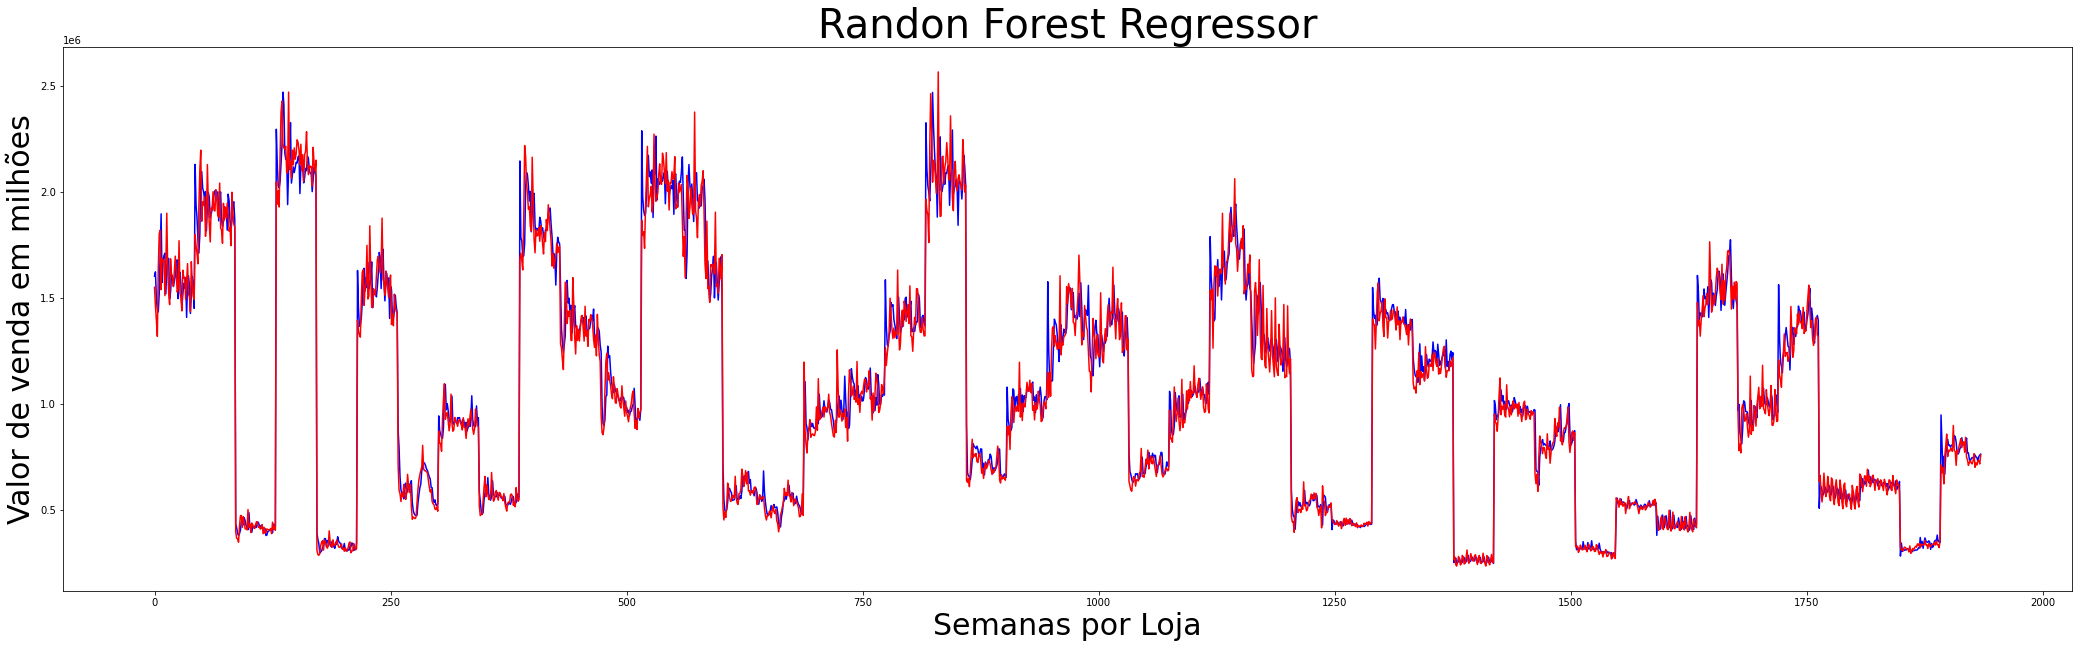

In [7]:
plt.figure(figsize = (36, 10)) 
plt.plot(range(len(predictions)), predictions, 'b')
plt.plot(range(len(predictions)), y_test, 'r')
plt.title("Randon Forest Regressor", fontsize=40)
plt.xlabel("Semanas por Loja", fontsize=30)
plt.ylabel("Valor de venda em milhões", fontsize=30)

plt.show() 

In [8]:
# for i in range(len(predictions)):
#   print("Valor real: {} Valor Predito: {}".format(y_test[i], predictions[i]))
  

In [9]:
# for i, feature in enumerate(rf.feature_names_in_):
#   print("Feature {}: {}".format(feature, rf.feature_importances_[i]))


Resultados Loja 1:
97784.15090455959 126412.24914244661


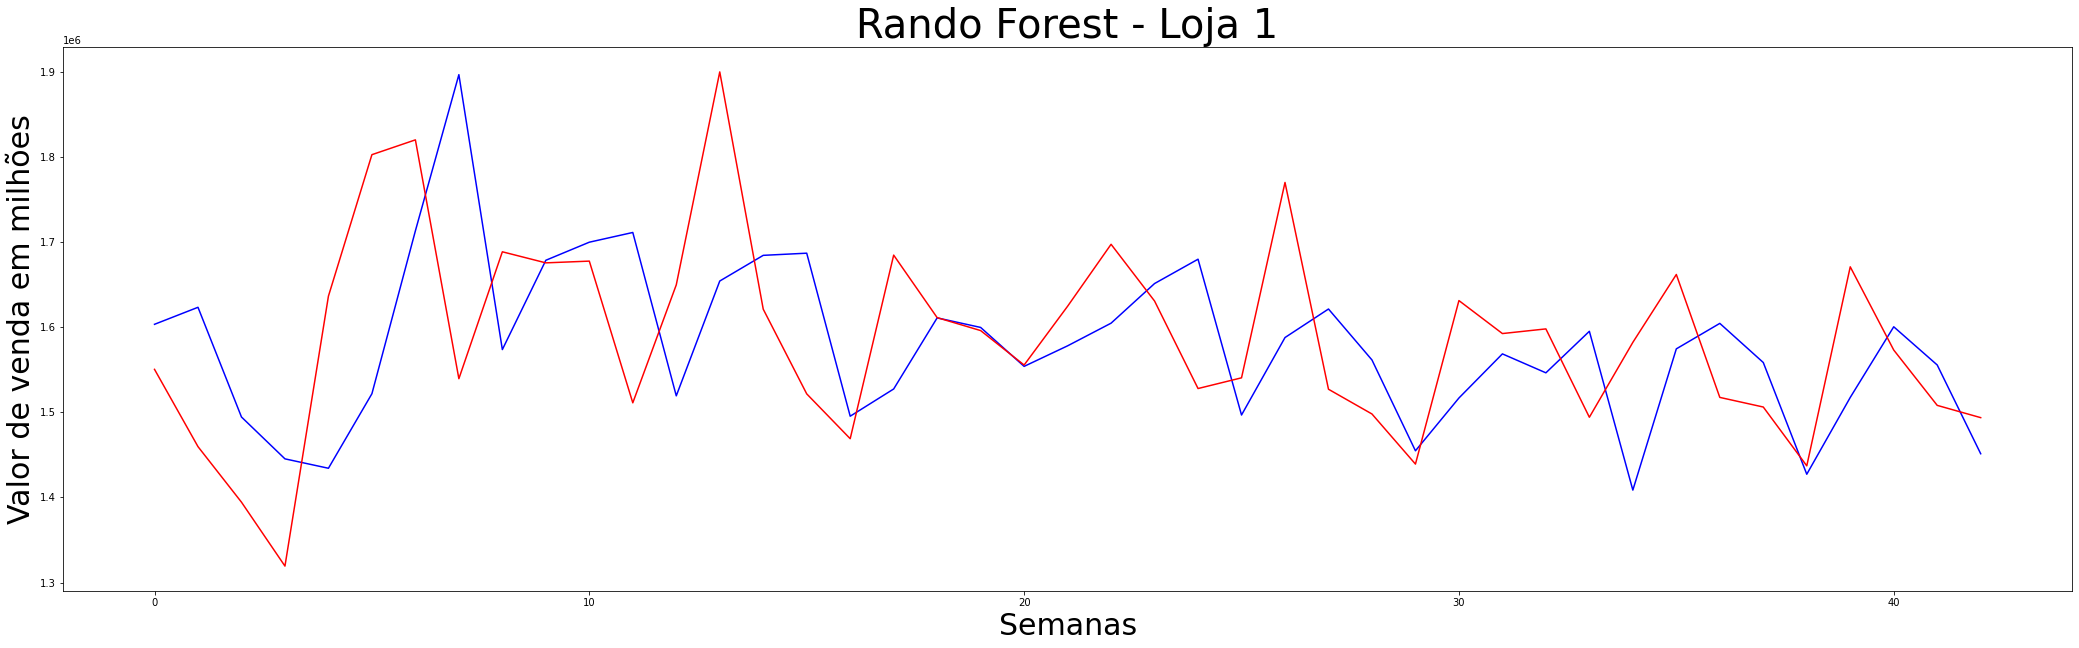

**************************************************
Resultados Loja 2:
101024.56578529334 126866.39765626768


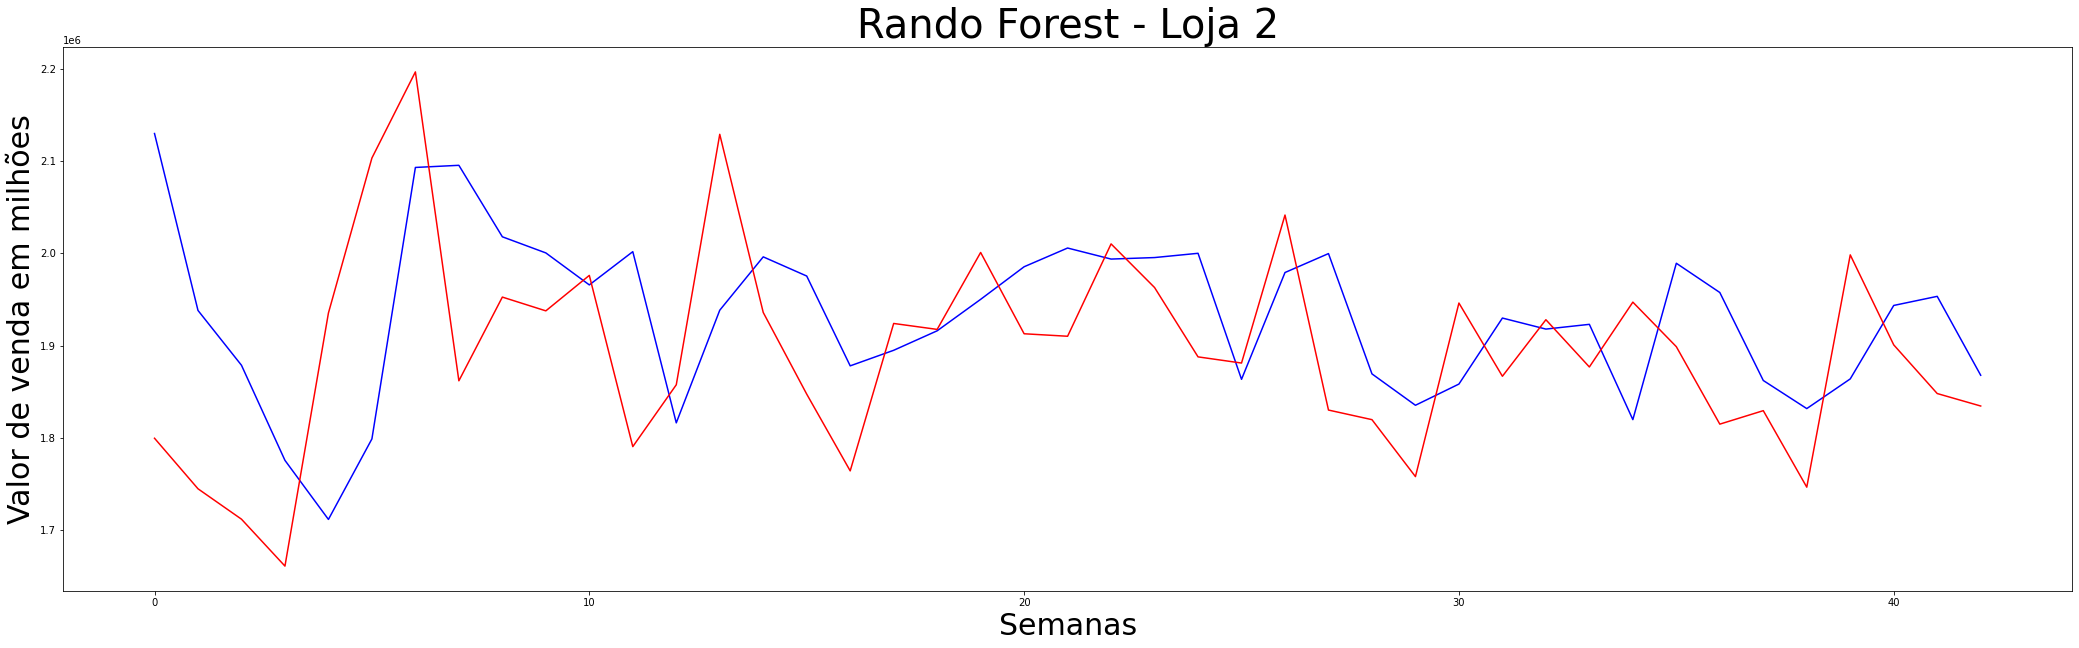

**************************************************
Resultados Loja 3:
25174.42662823666 31708.75280124888


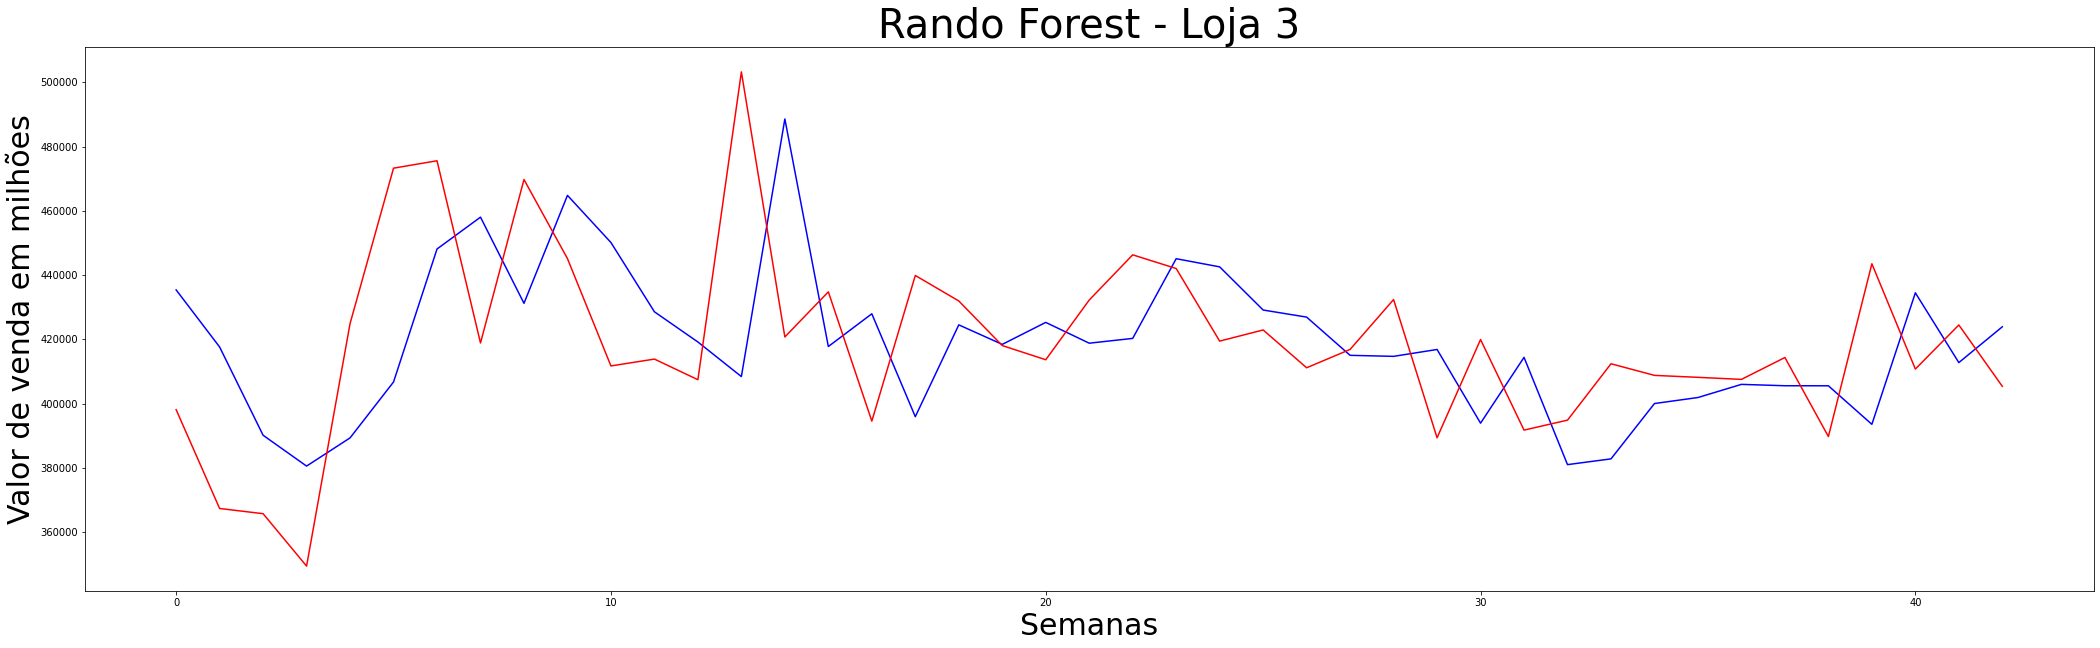

**************************************************
Resultados Loja 4:
98650.53995641078 127993.43403454126


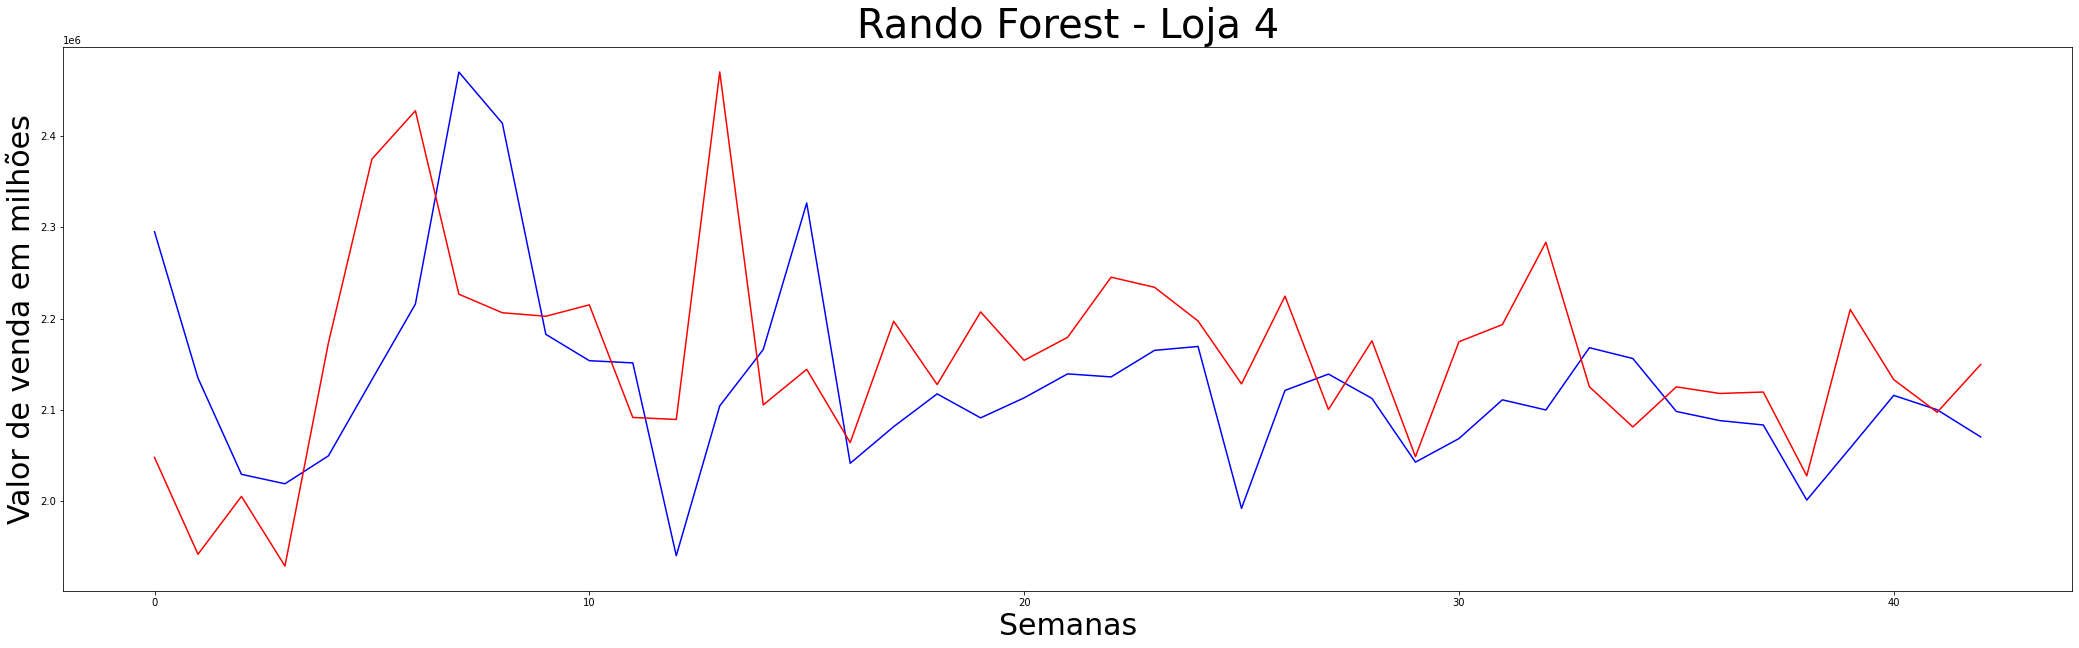

**************************************************
Resultados Loja 5:
22917.574368203903 29006.267926991517


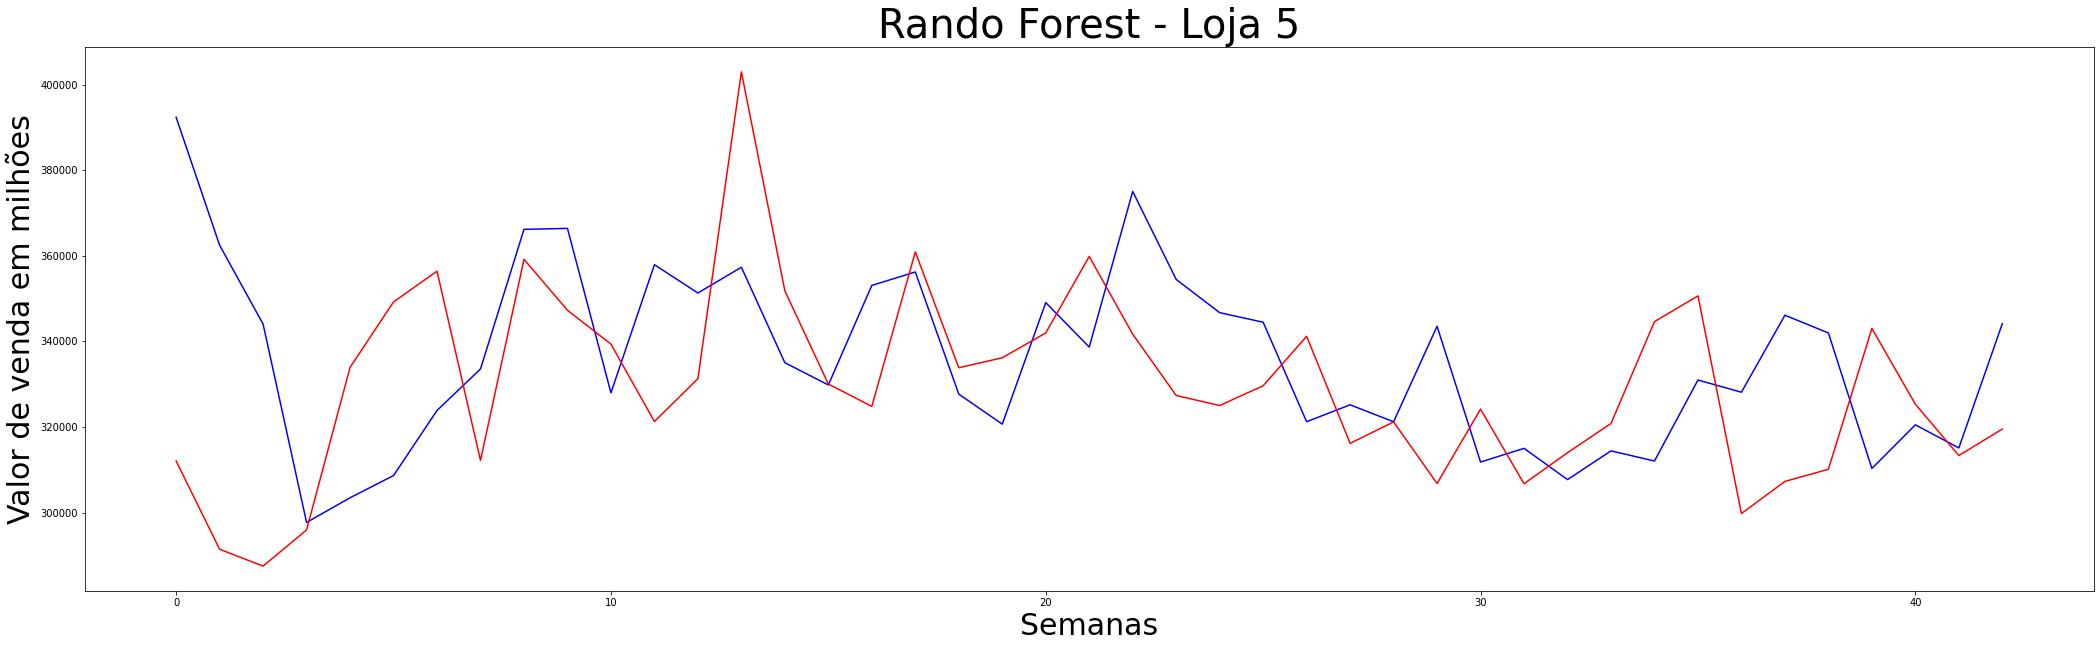

**************************************************
Resultados Loja 6:
84675.6639947949 111559.83691818808


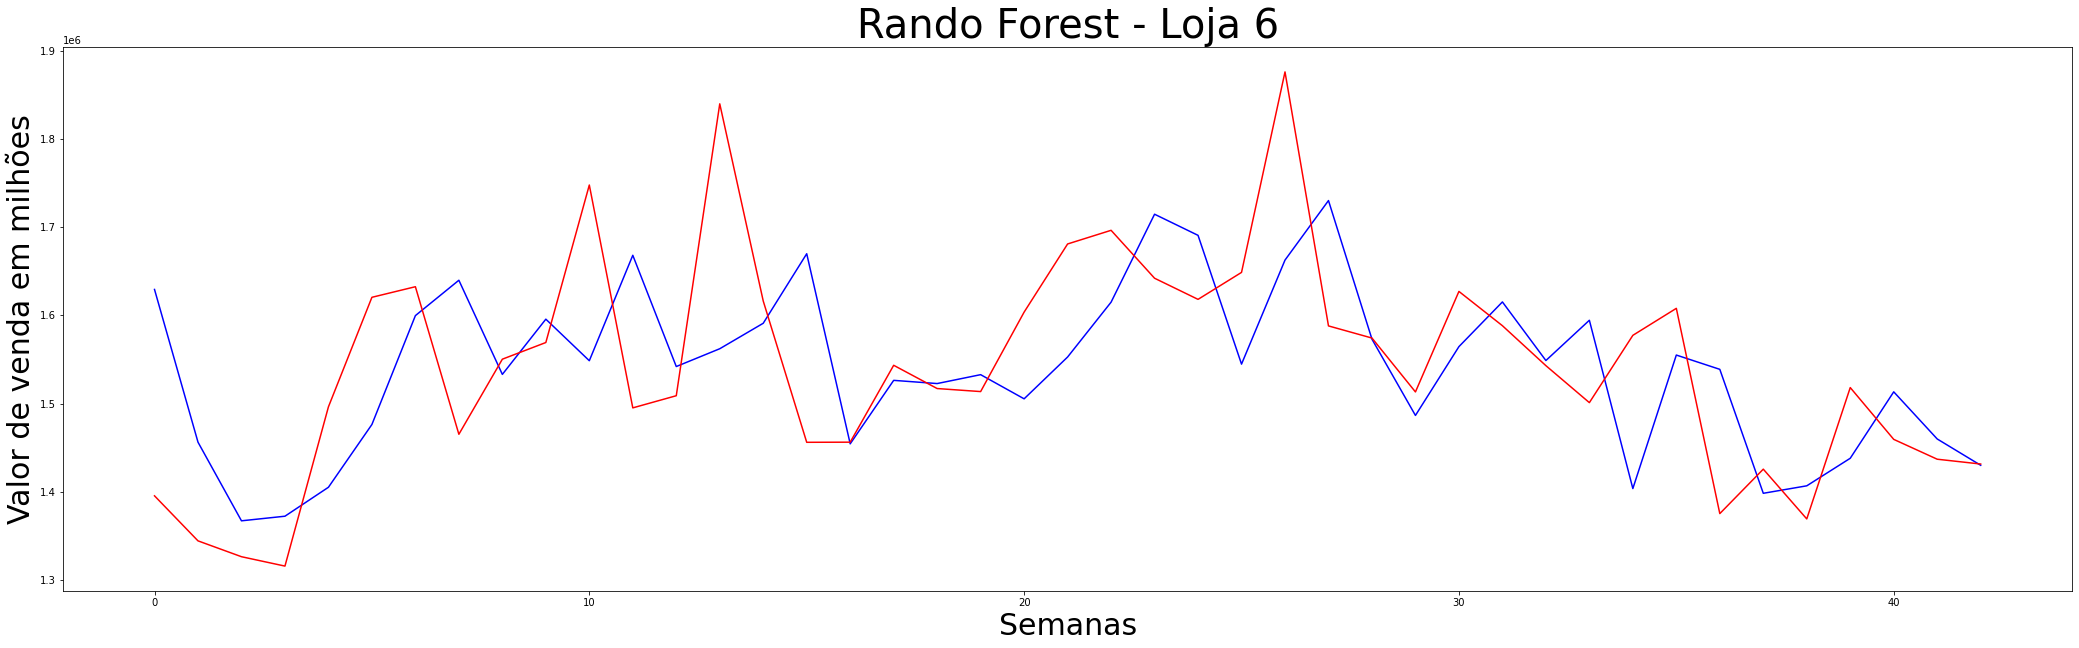

**************************************************
Resultados Loja 7:
46930.903239931155 62680.94897199498


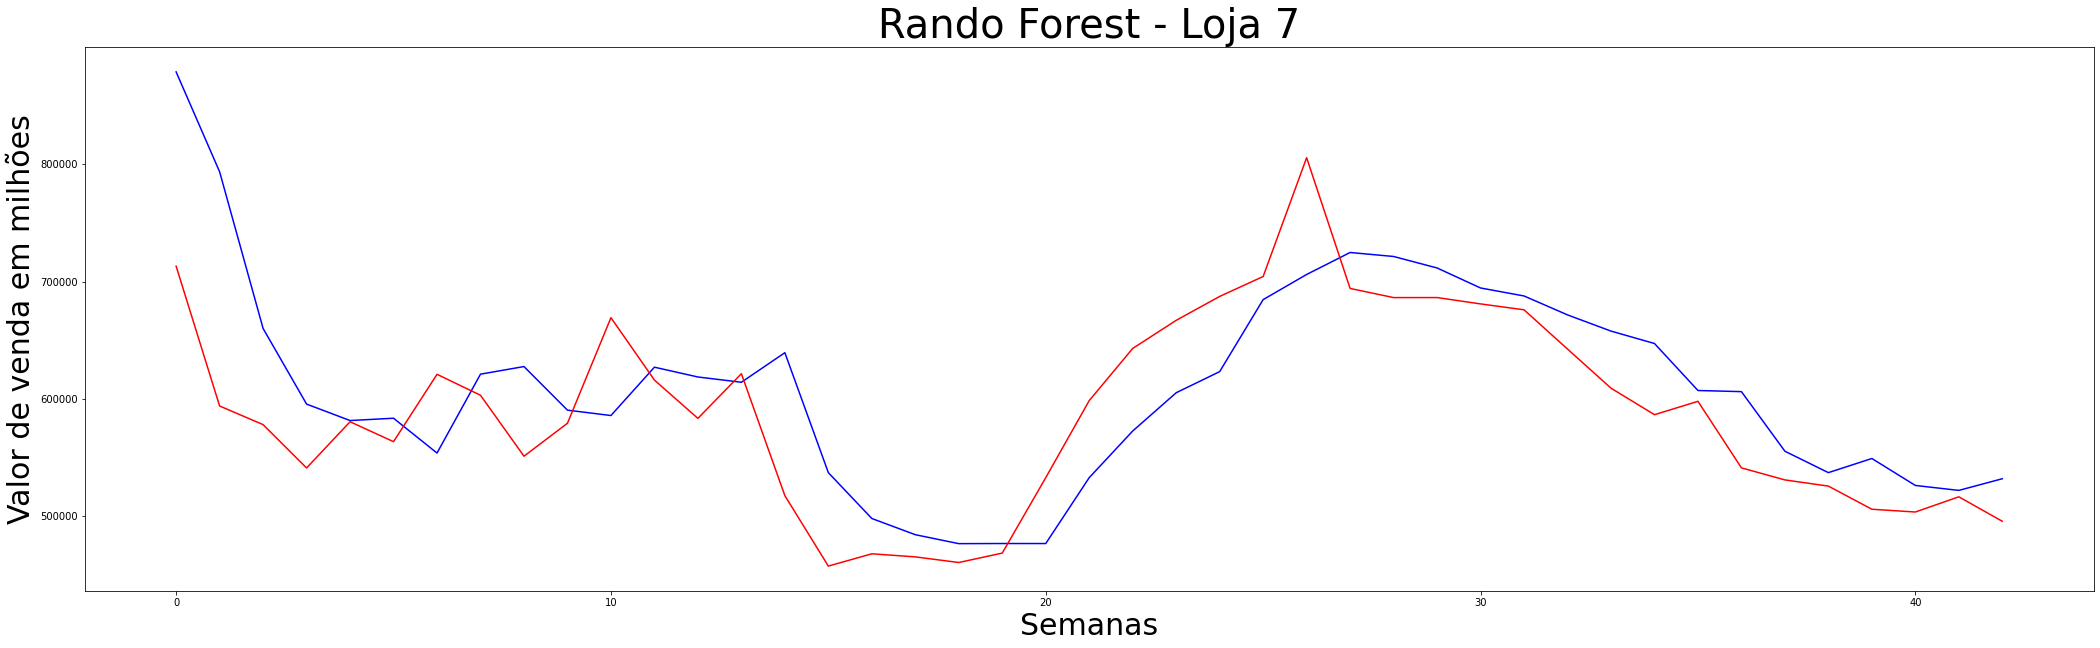

**************************************************
Resultados Loja 8:
45300.12583531236 59311.60109801222


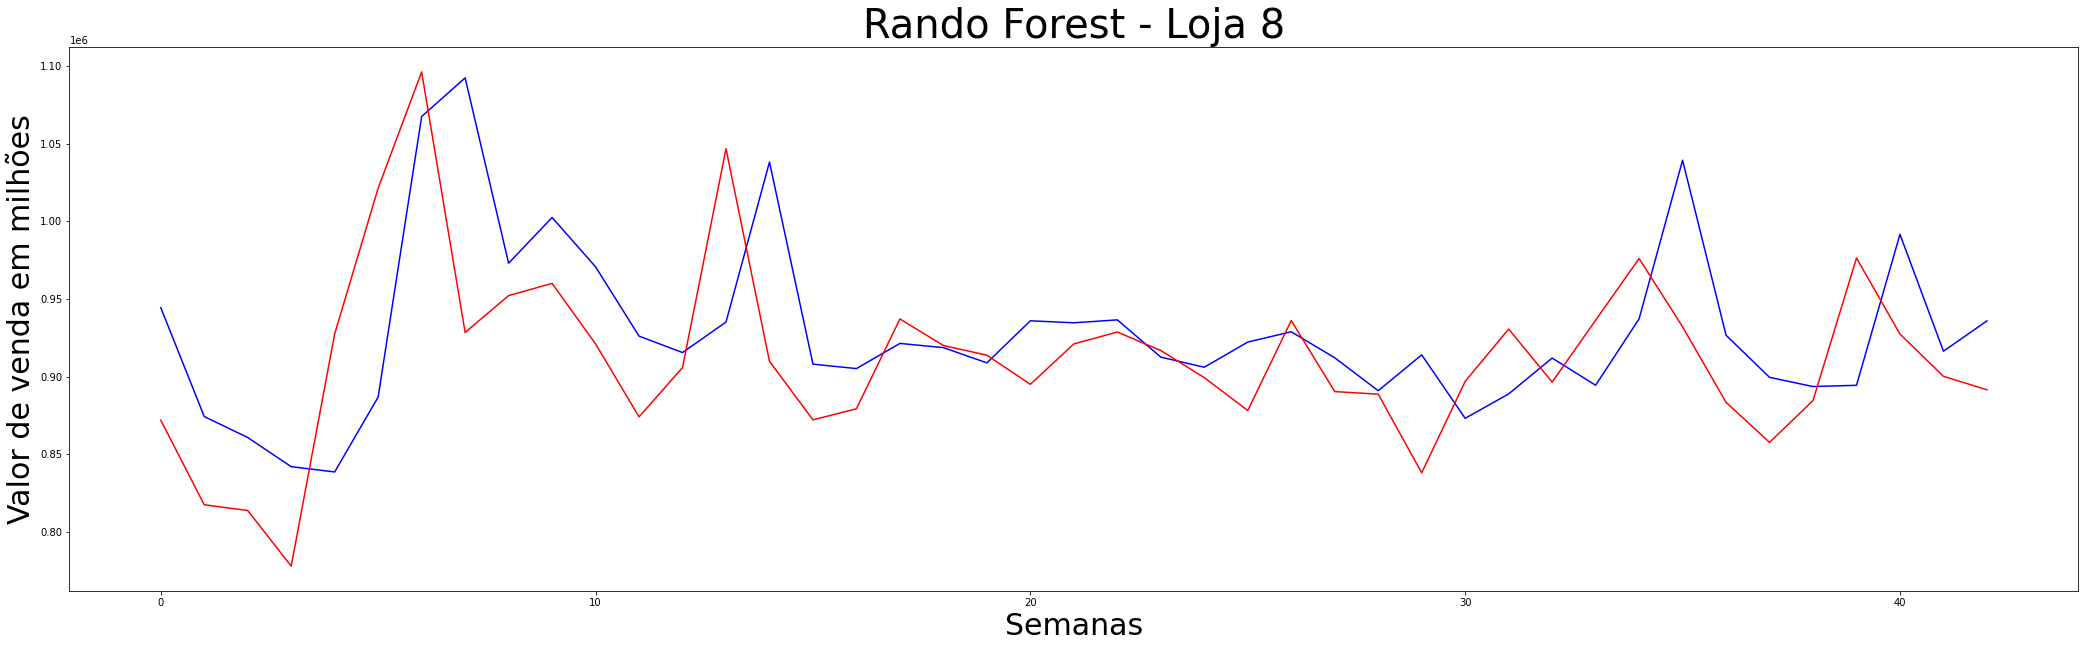

**************************************************
Resultados Loja 9:
29616.79356345696 39396.5161155477


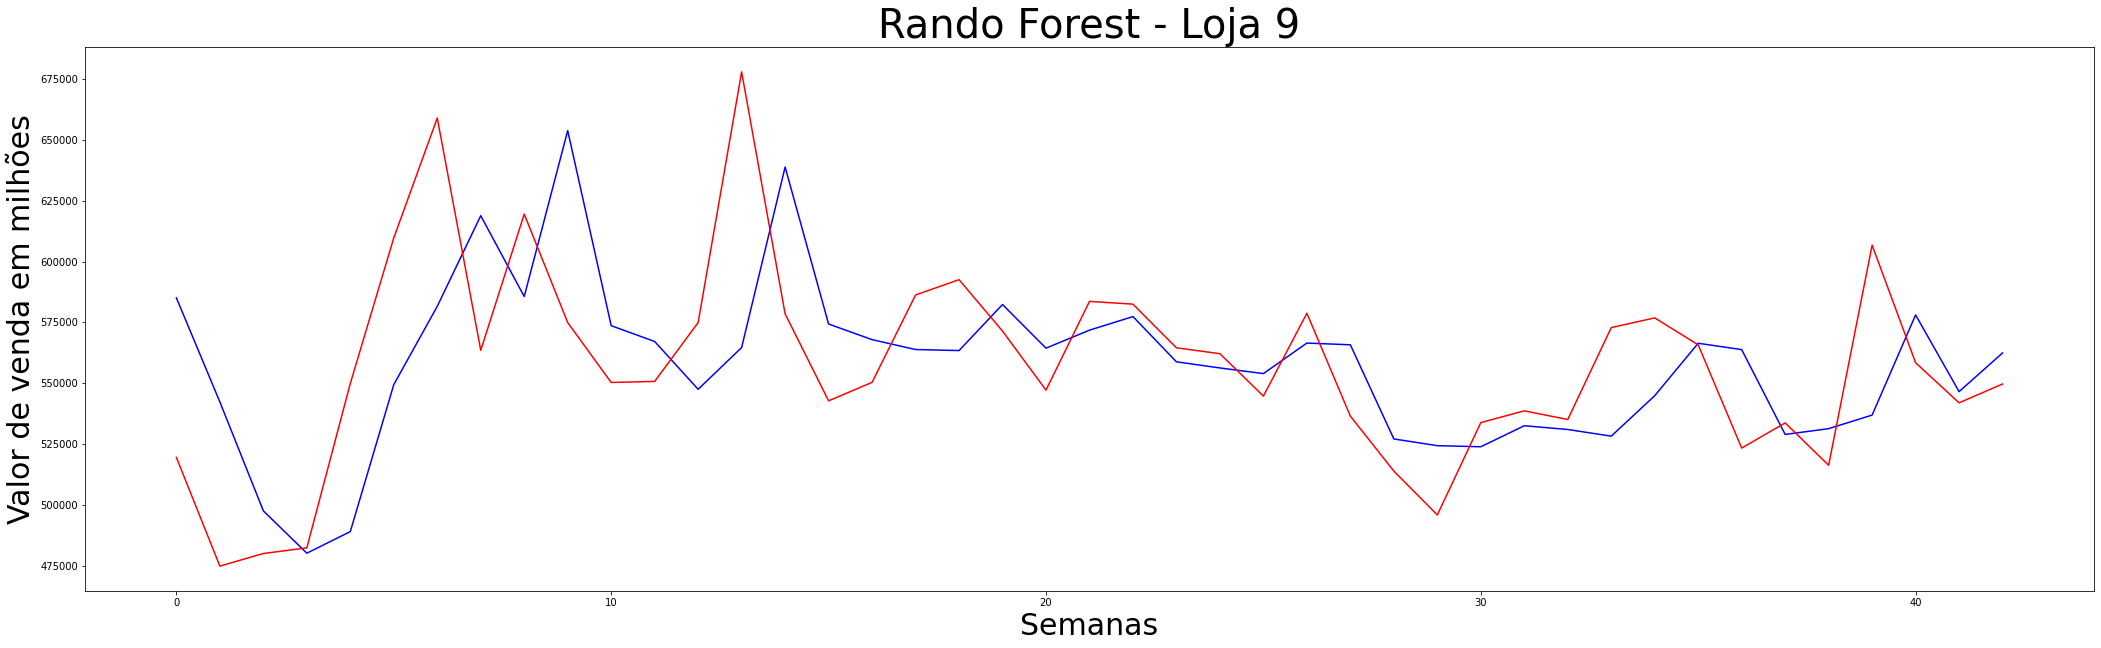

**************************************************
Resultados Loja 10:
90540.67173680721 135111.3939362587


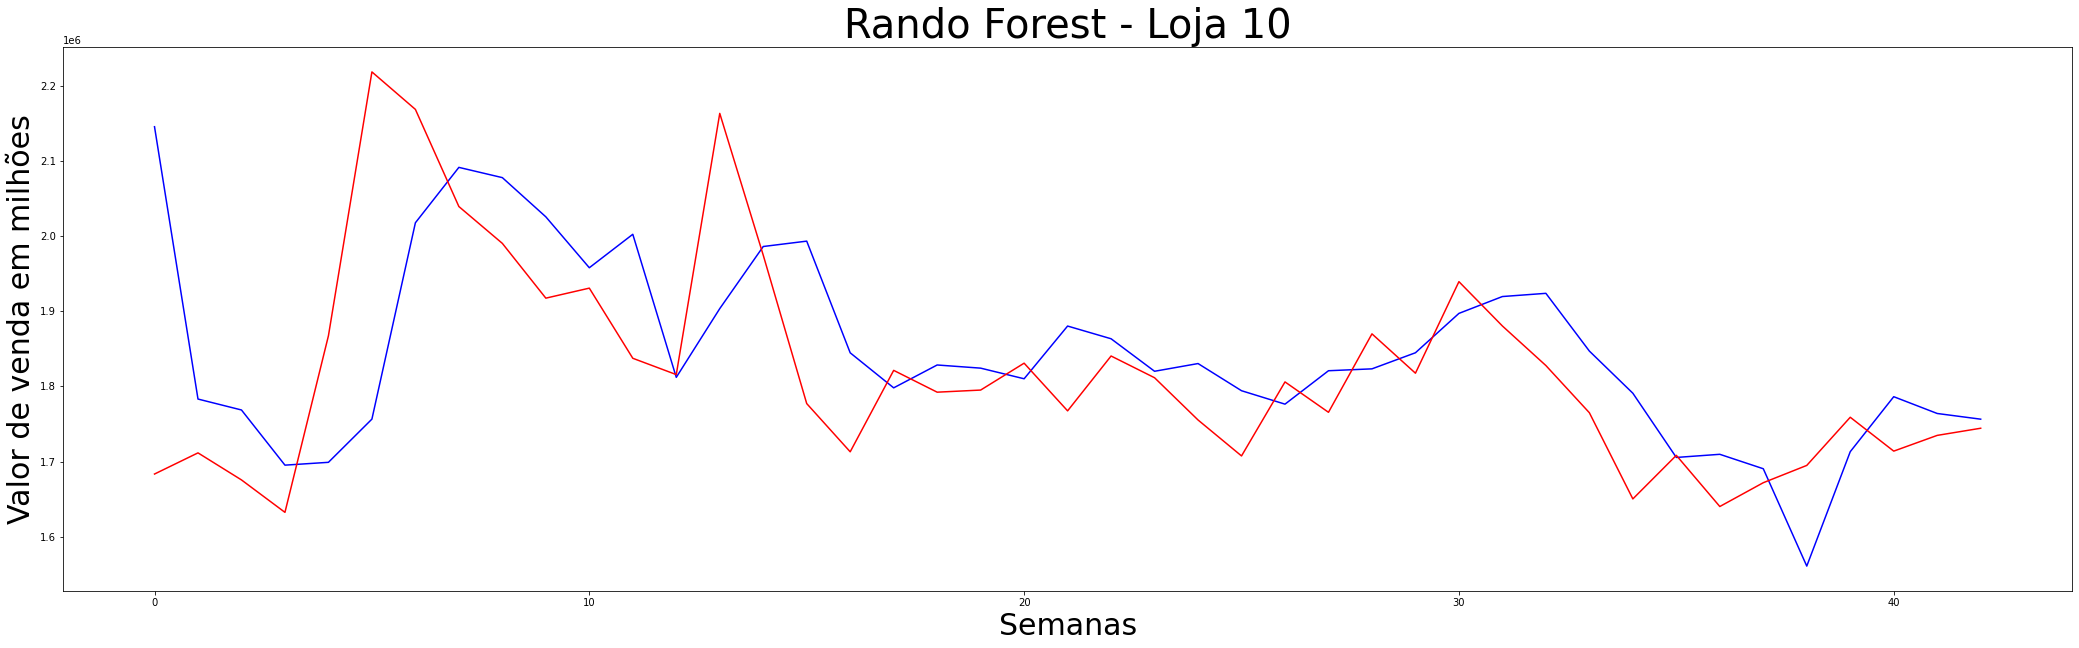

**************************************************
Resultados Loja 11:
76667.462974107 100733.80730825594


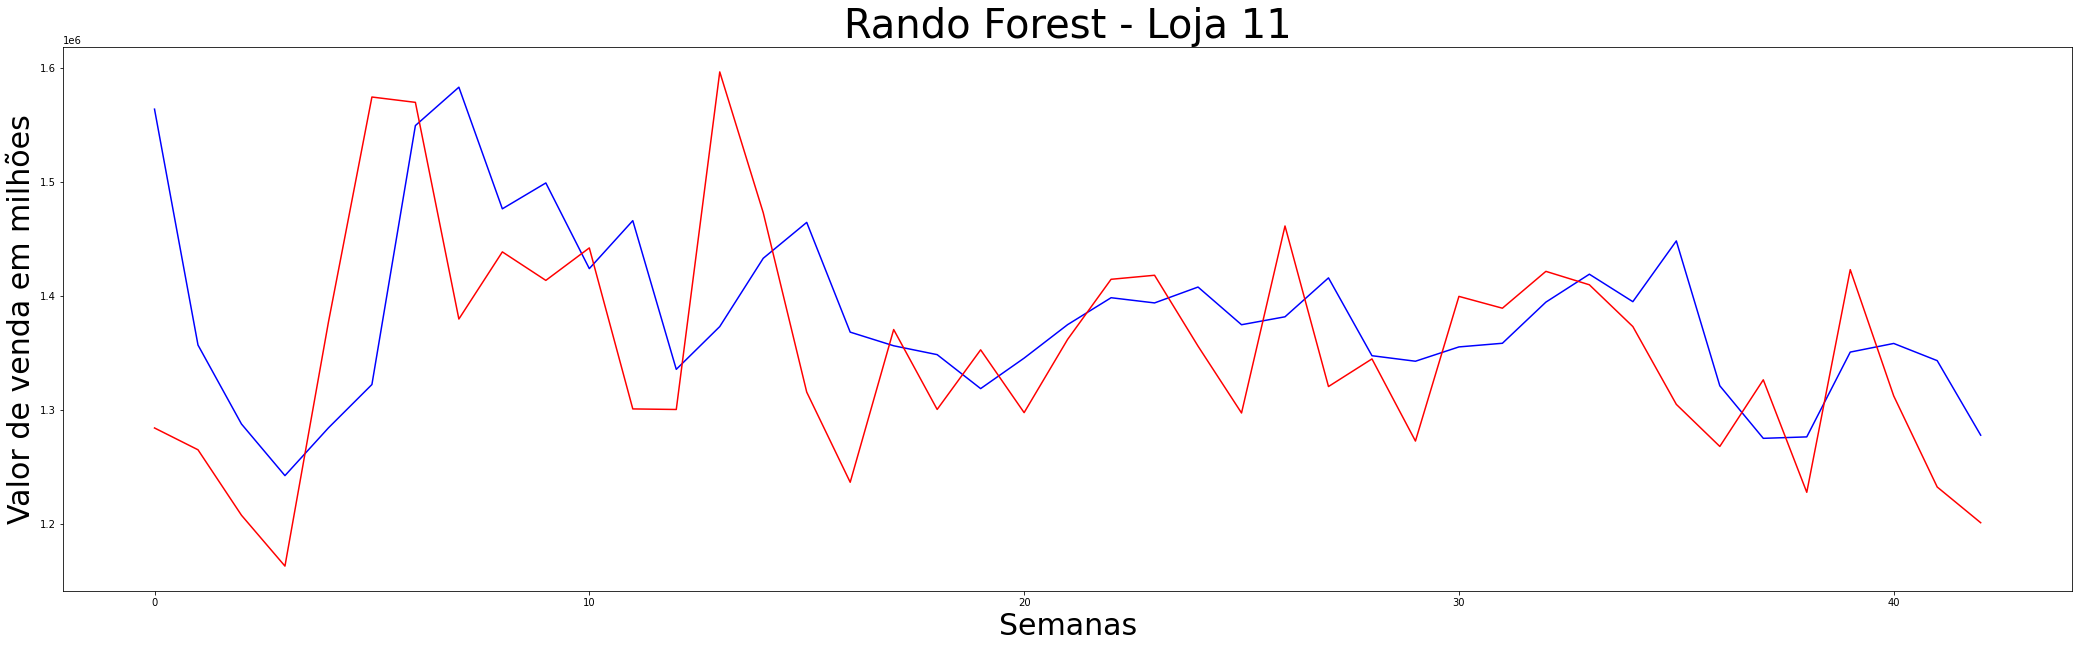

**************************************************
Resultados Loja 12:
62879.57823772057 85691.16007697157


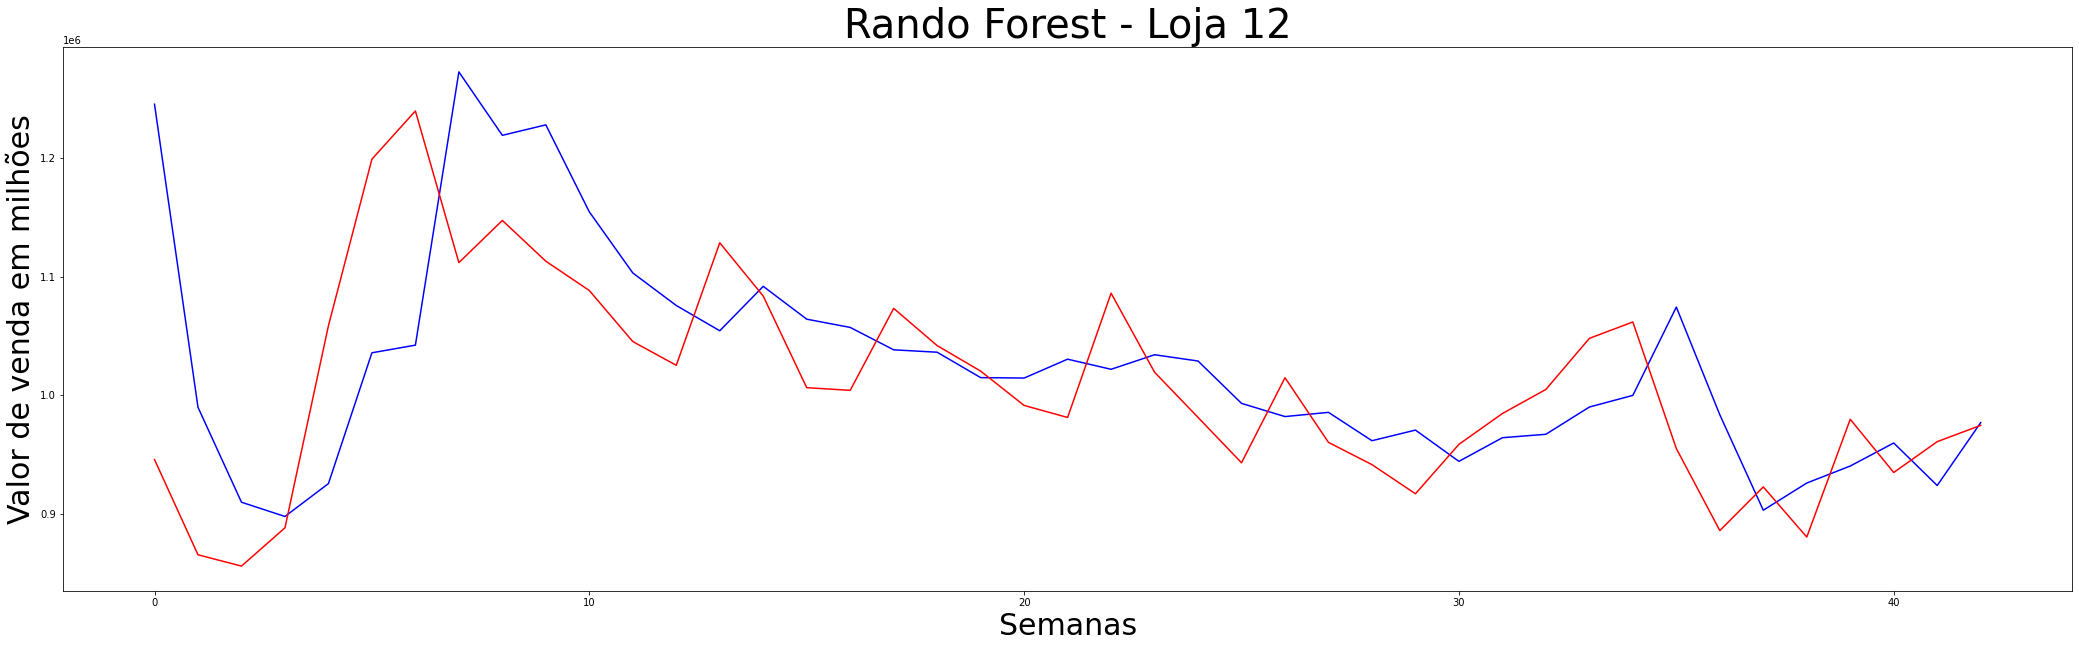

**************************************************
Resultados Loja 13:
93902.94987450639 127195.35917842745


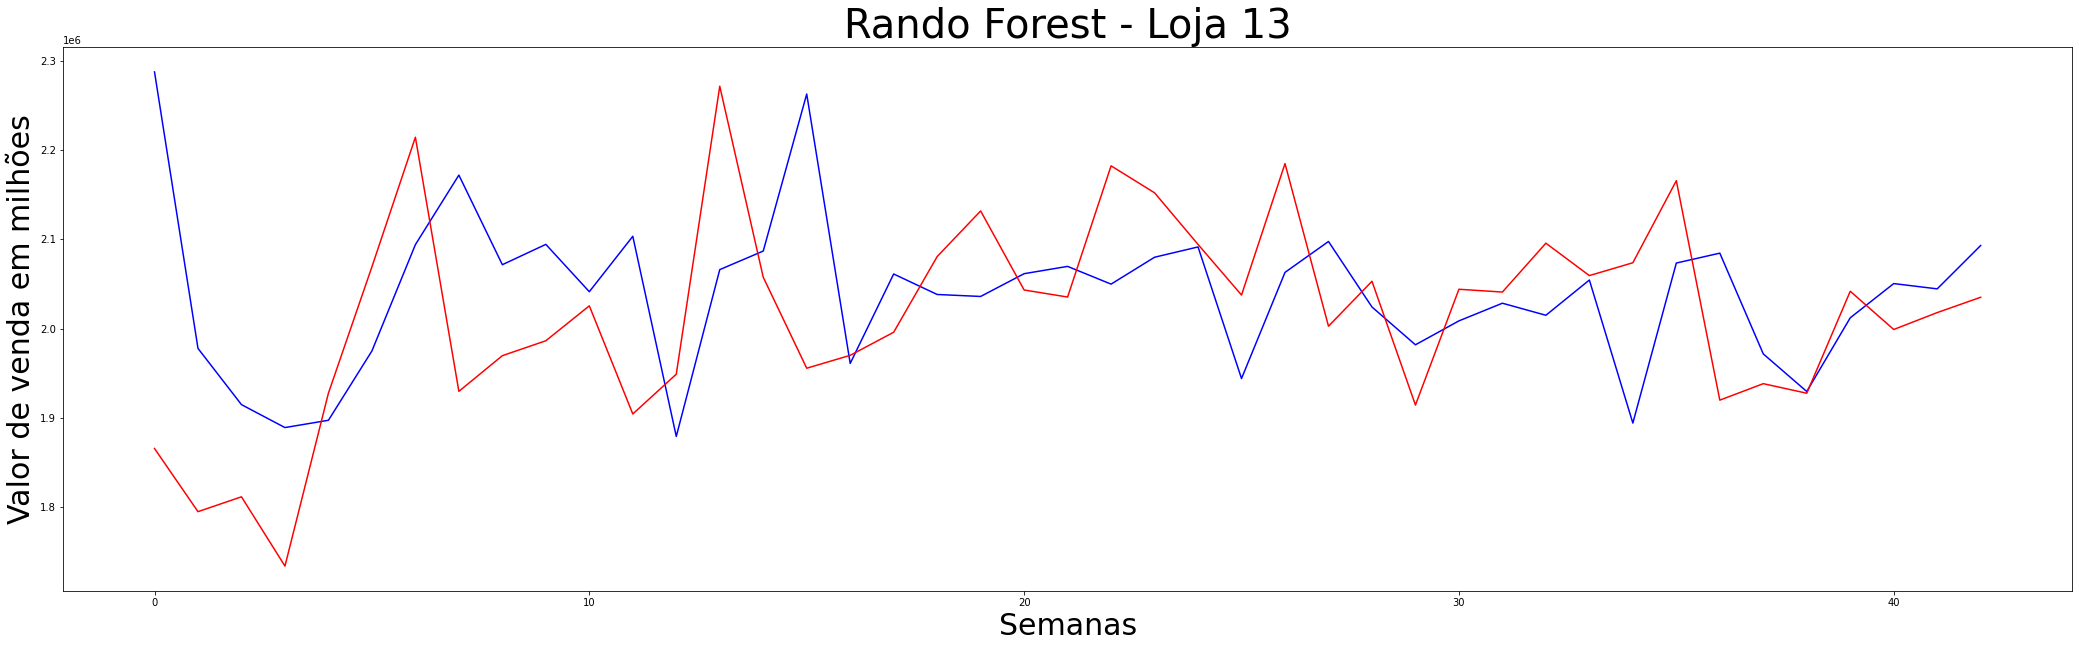

**************************************************
Resultados Loja 14:
129573.2299738324 166863.11867824267


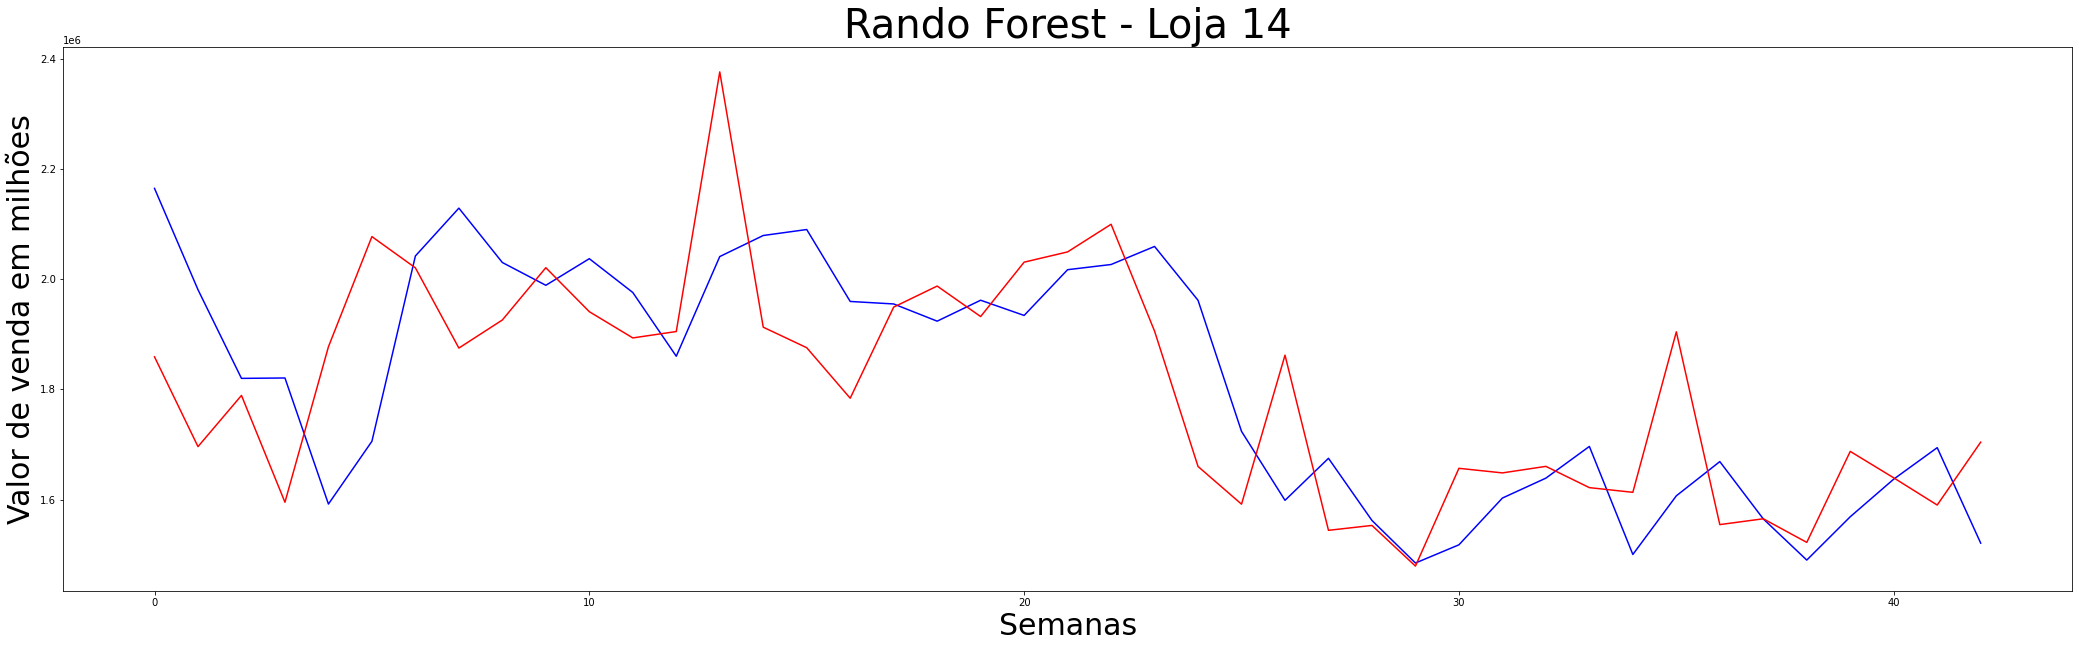

**************************************************
Resultados Loja 15:
35984.49175736536 52038.108905884794


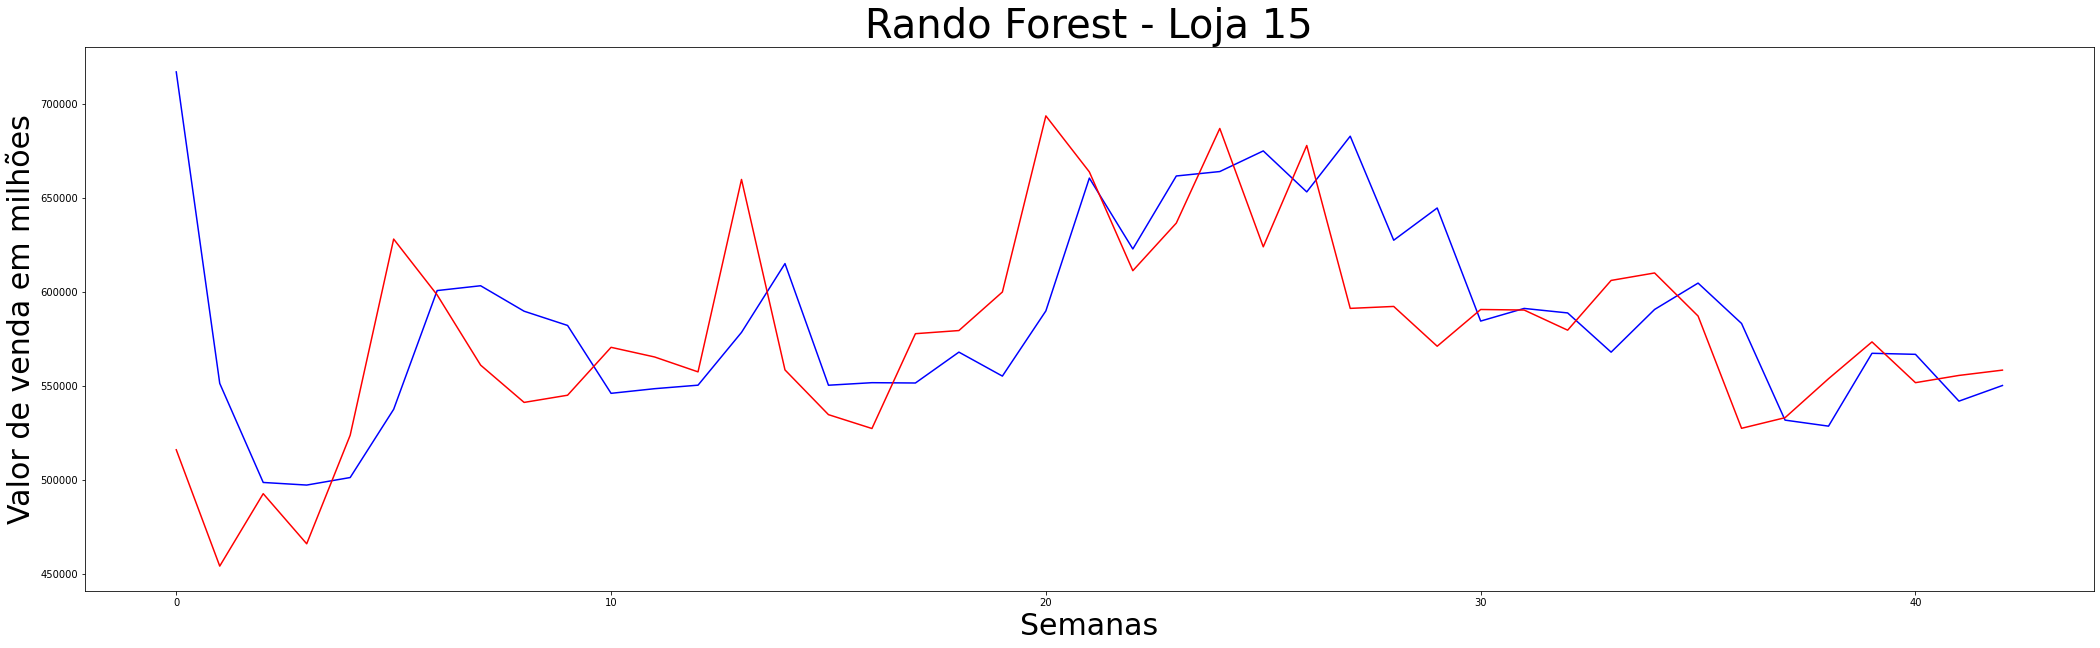

**************************************************
Resultados Loja 16:
33433.30560825372 42676.68034442581


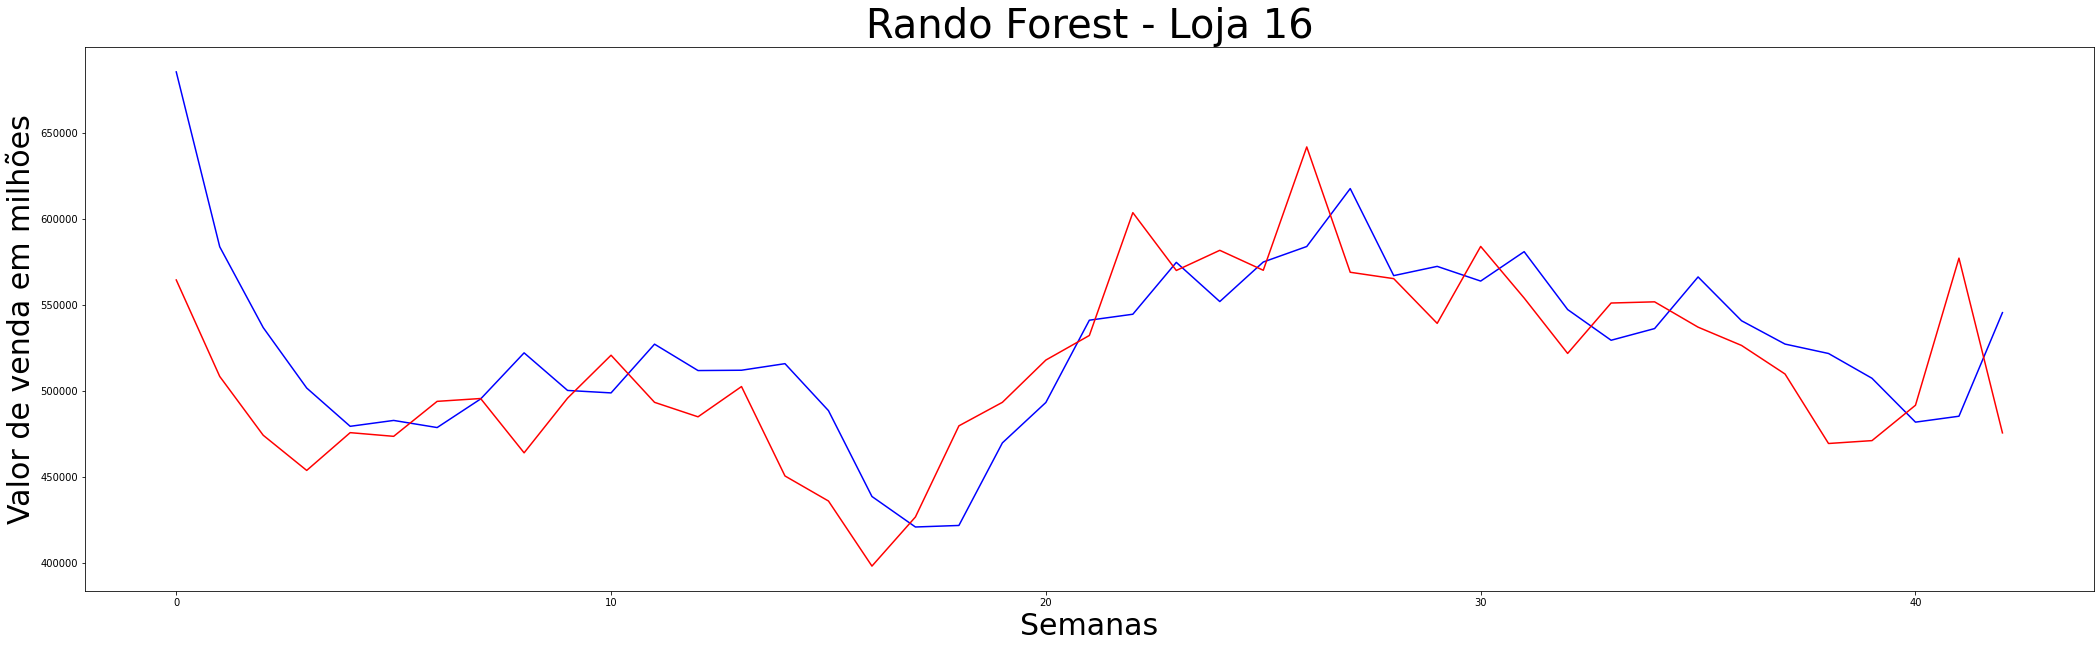

**************************************************
Resultados Loja 17:
66205.48306248142 96143.44236681778


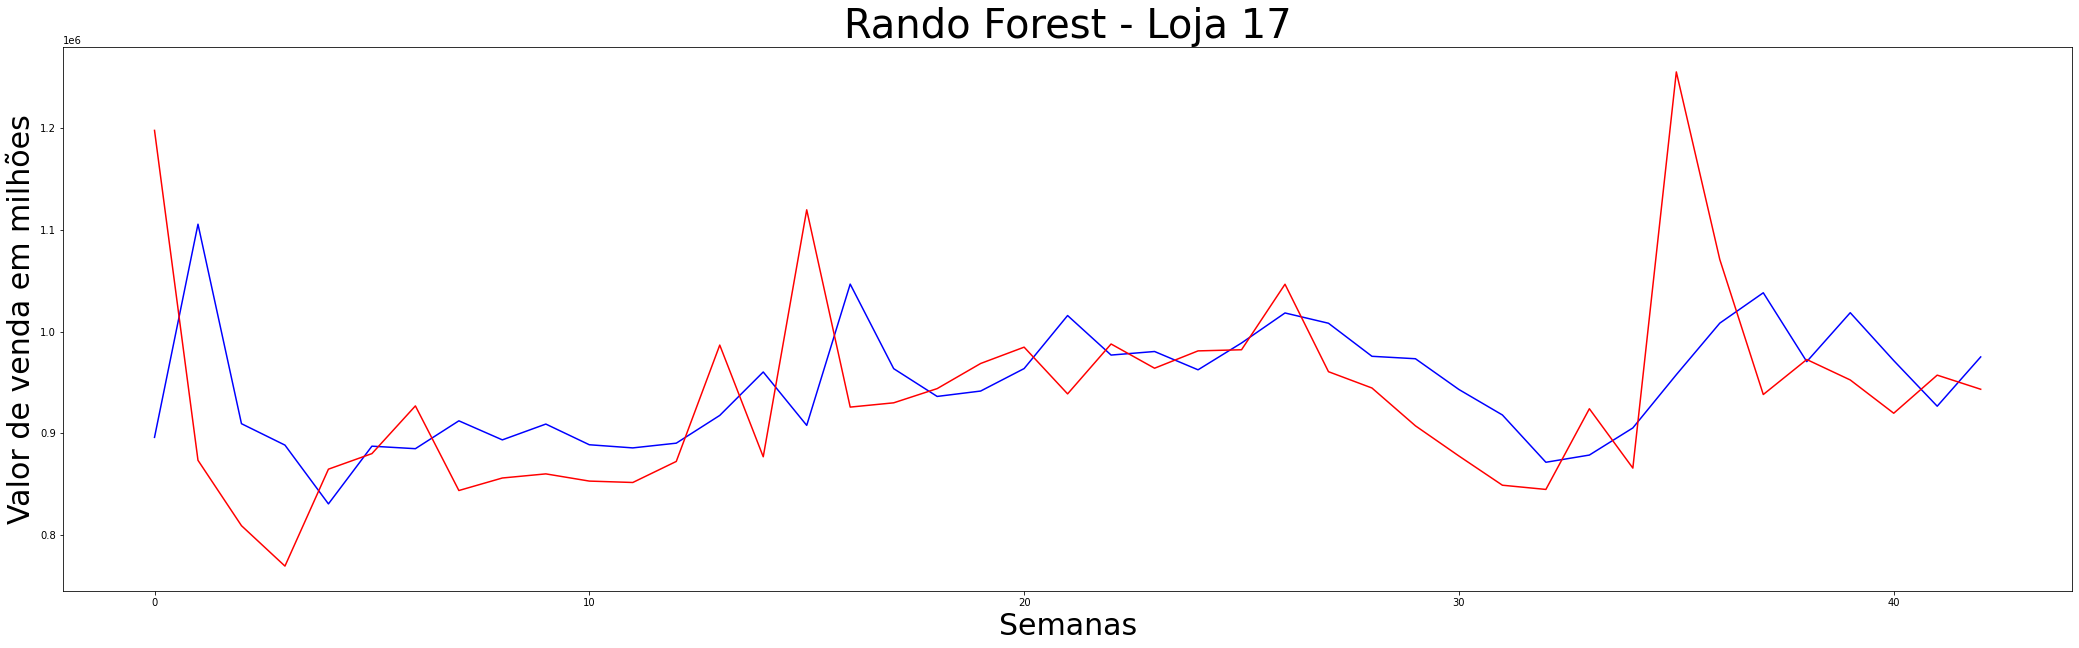

**************************************************
Resultados Loja 18:
72782.83188713982 91438.9784459061


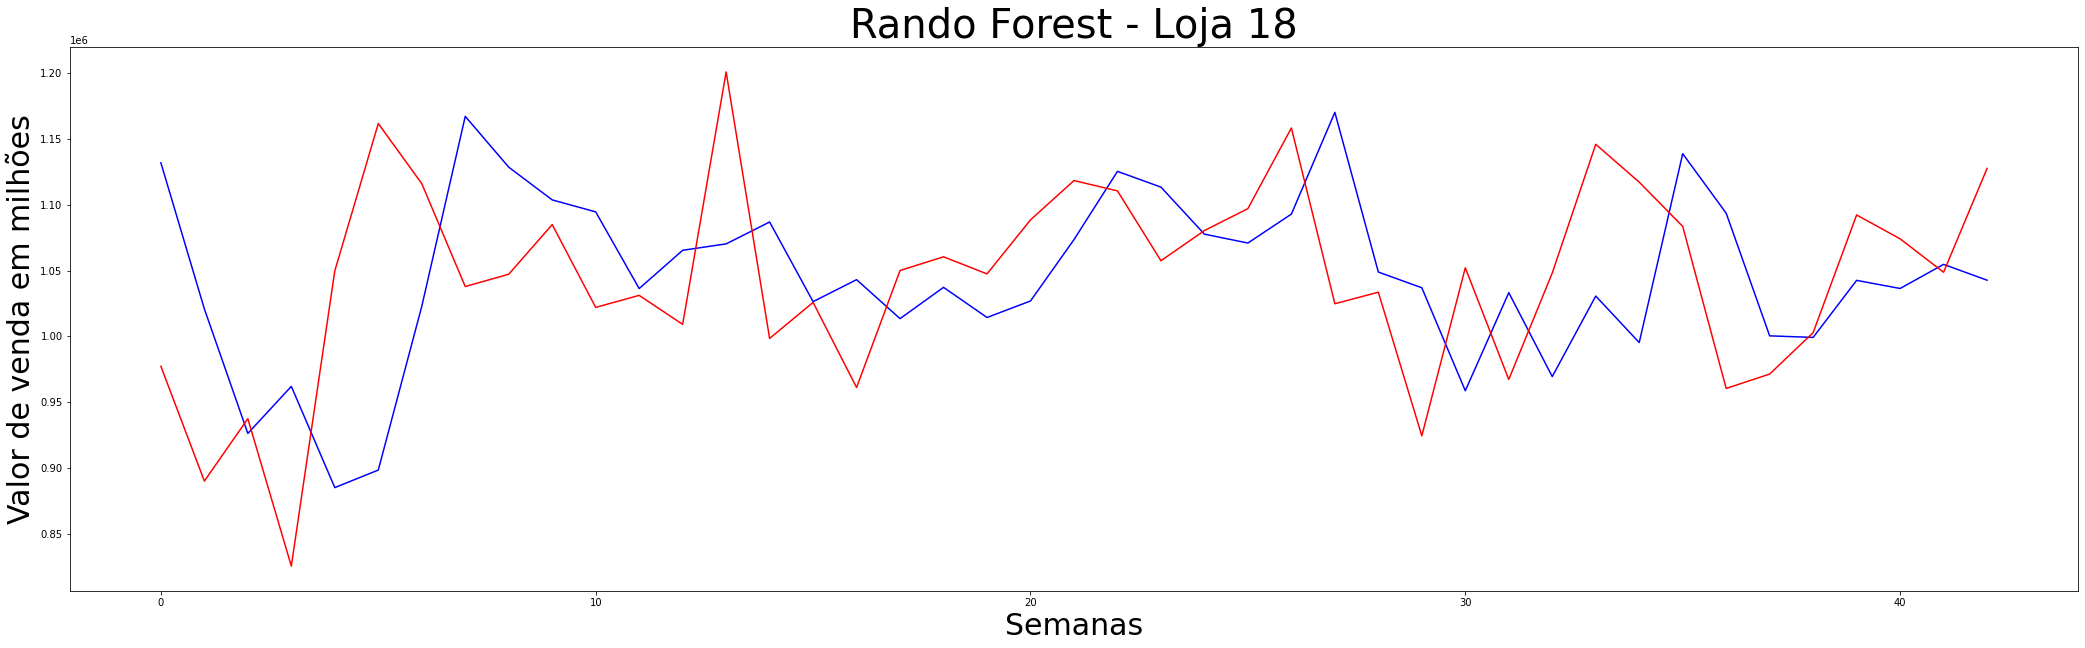

**************************************************
Resultados Loja 19:
79814.23483940937 104163.92656313913


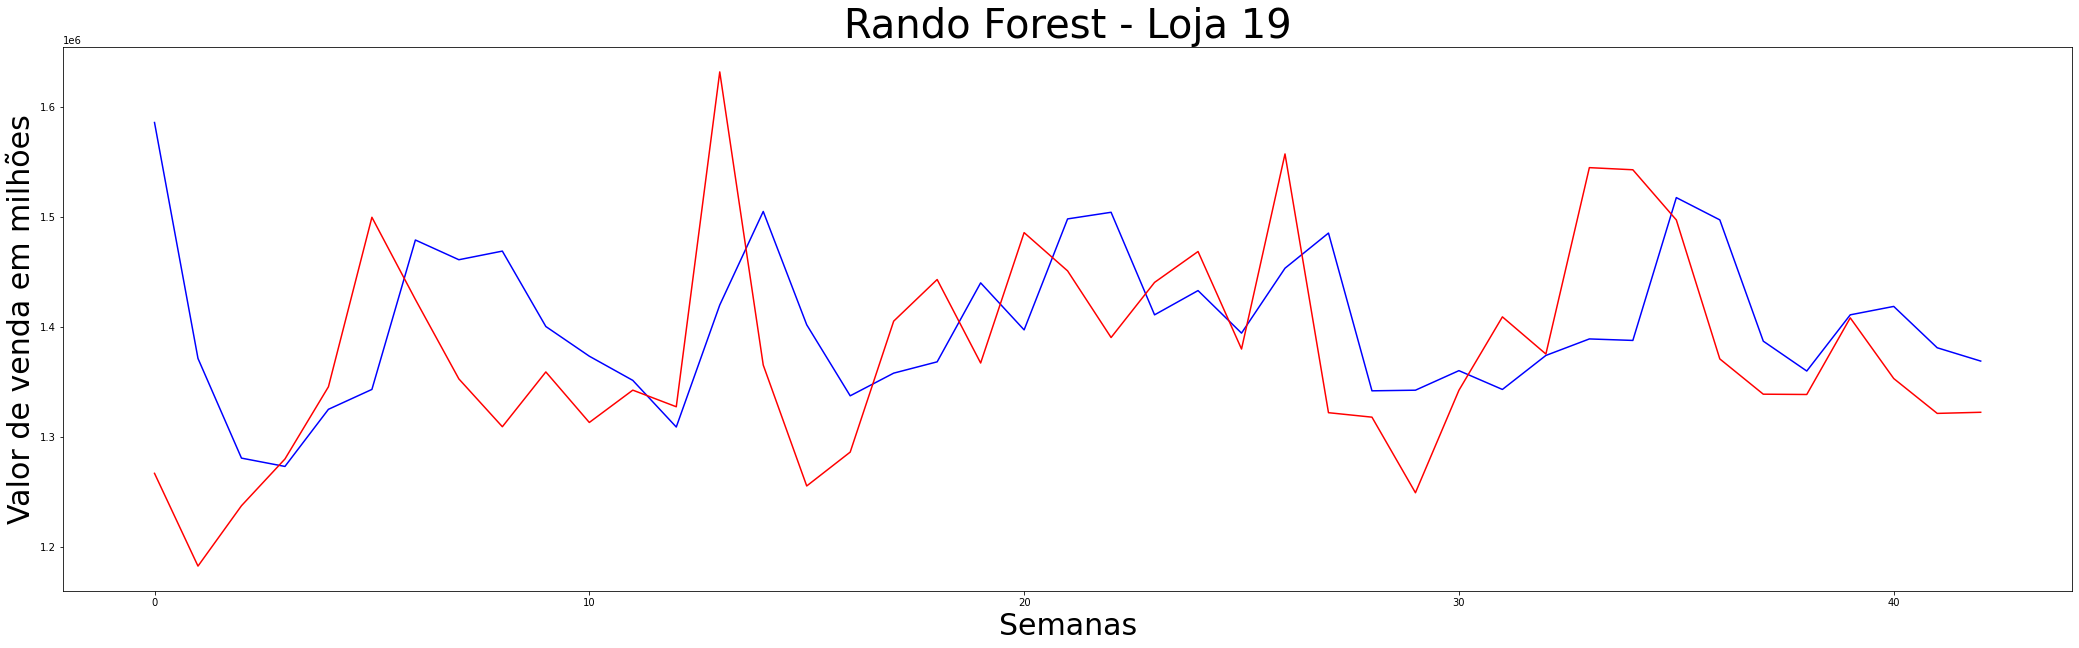

**************************************************
Resultados Loja 20:
141850.8746989507 186494.3762643627


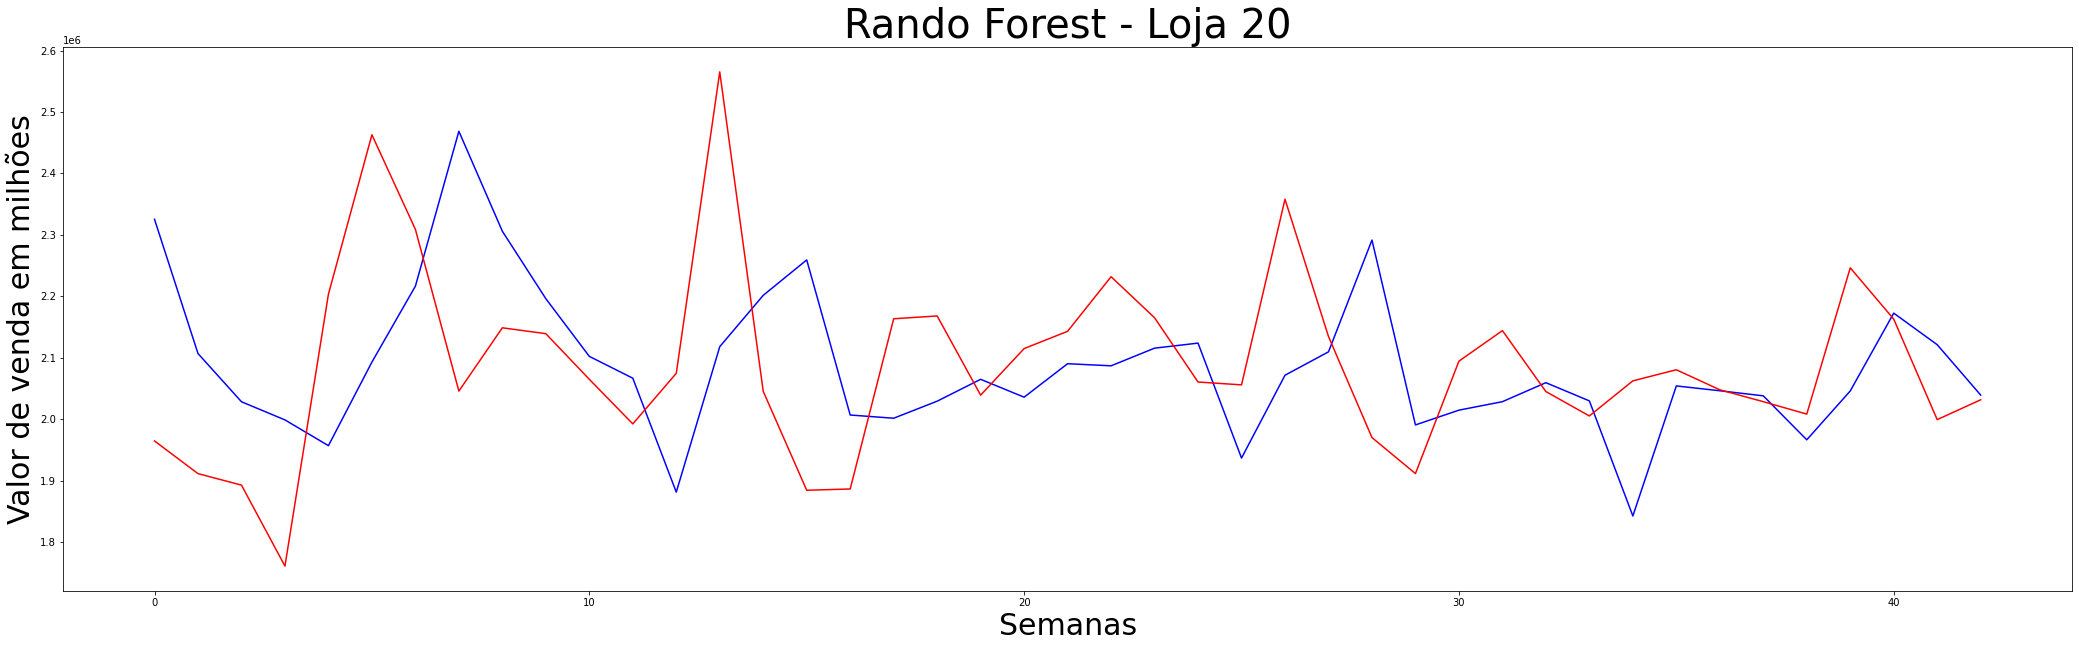

**************************************************
Resultados Loja 21:
42595.320005819616 63033.93198743939


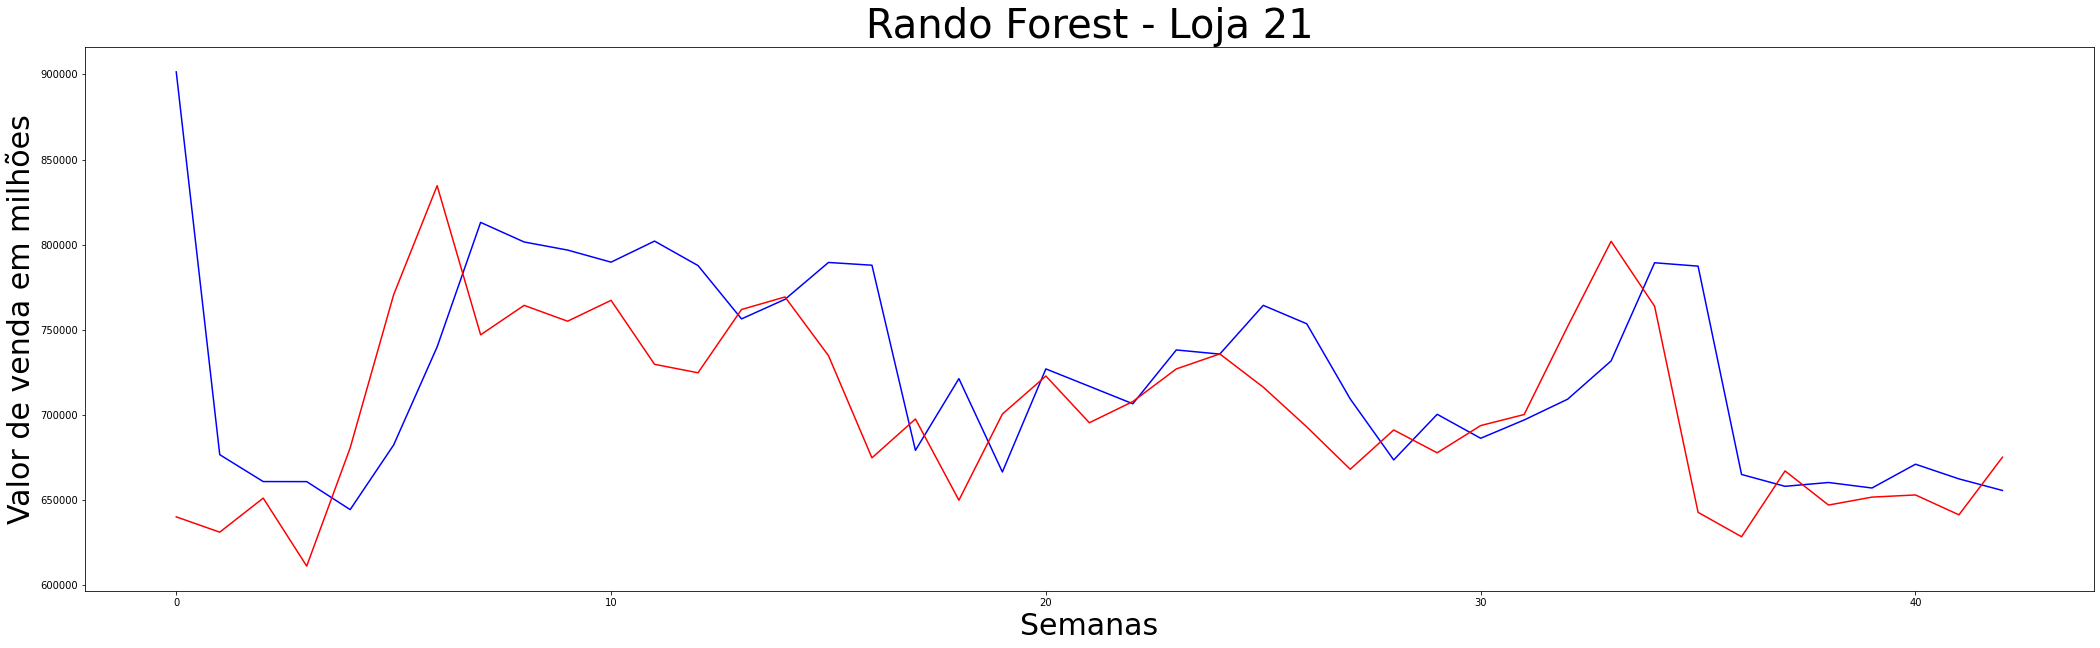

**************************************************
Resultados Loja 22:
60471.805205633245 78477.13376641668


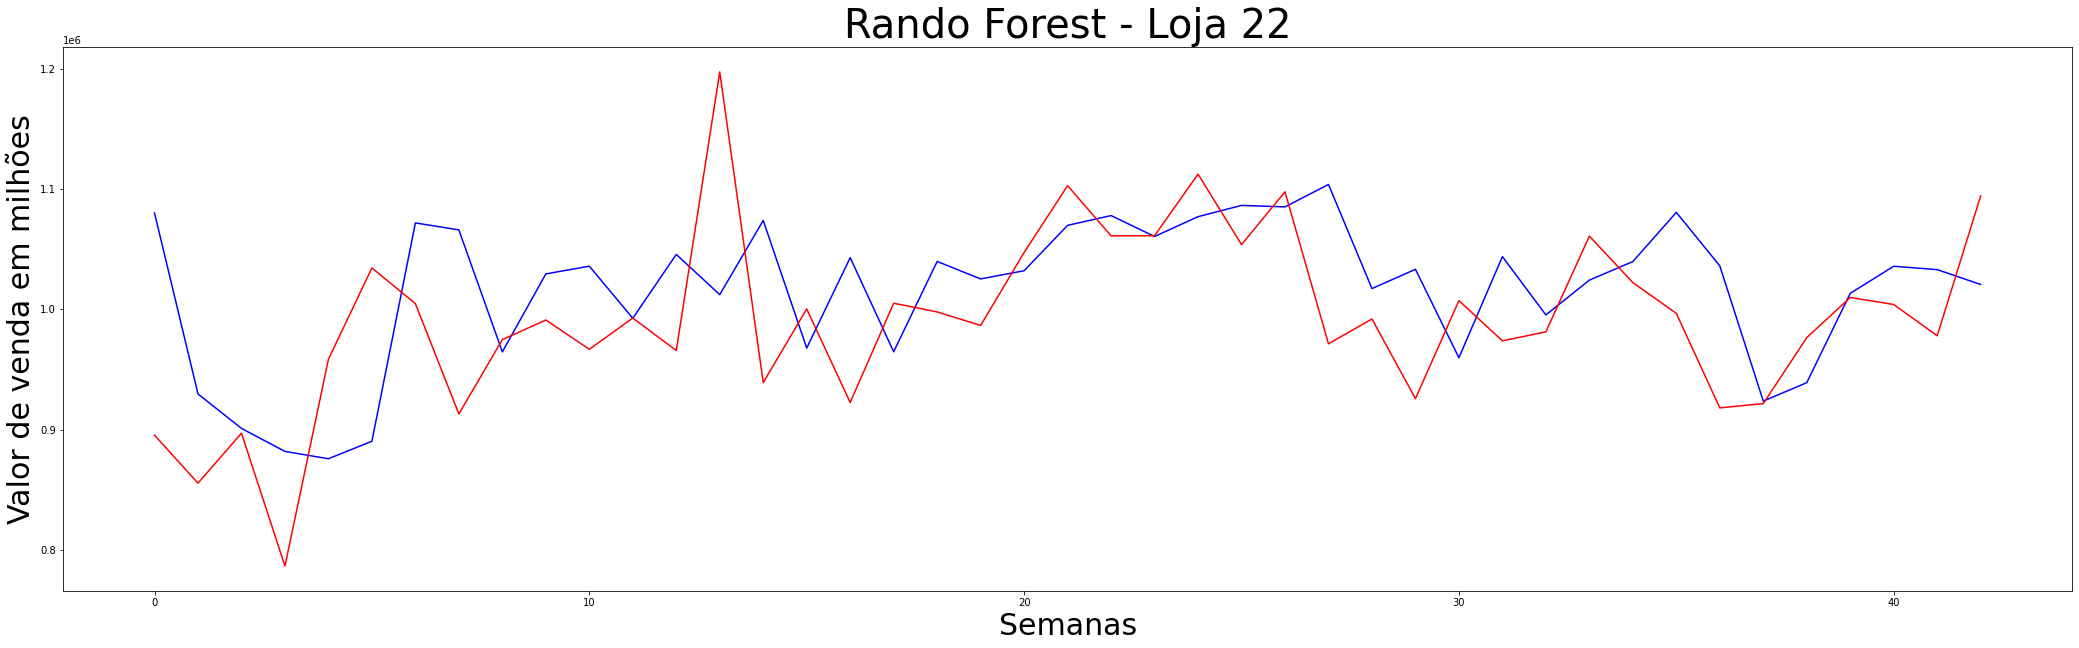

**************************************************
Resultados Loja 23:
87462.85898449794 123294.03501491682


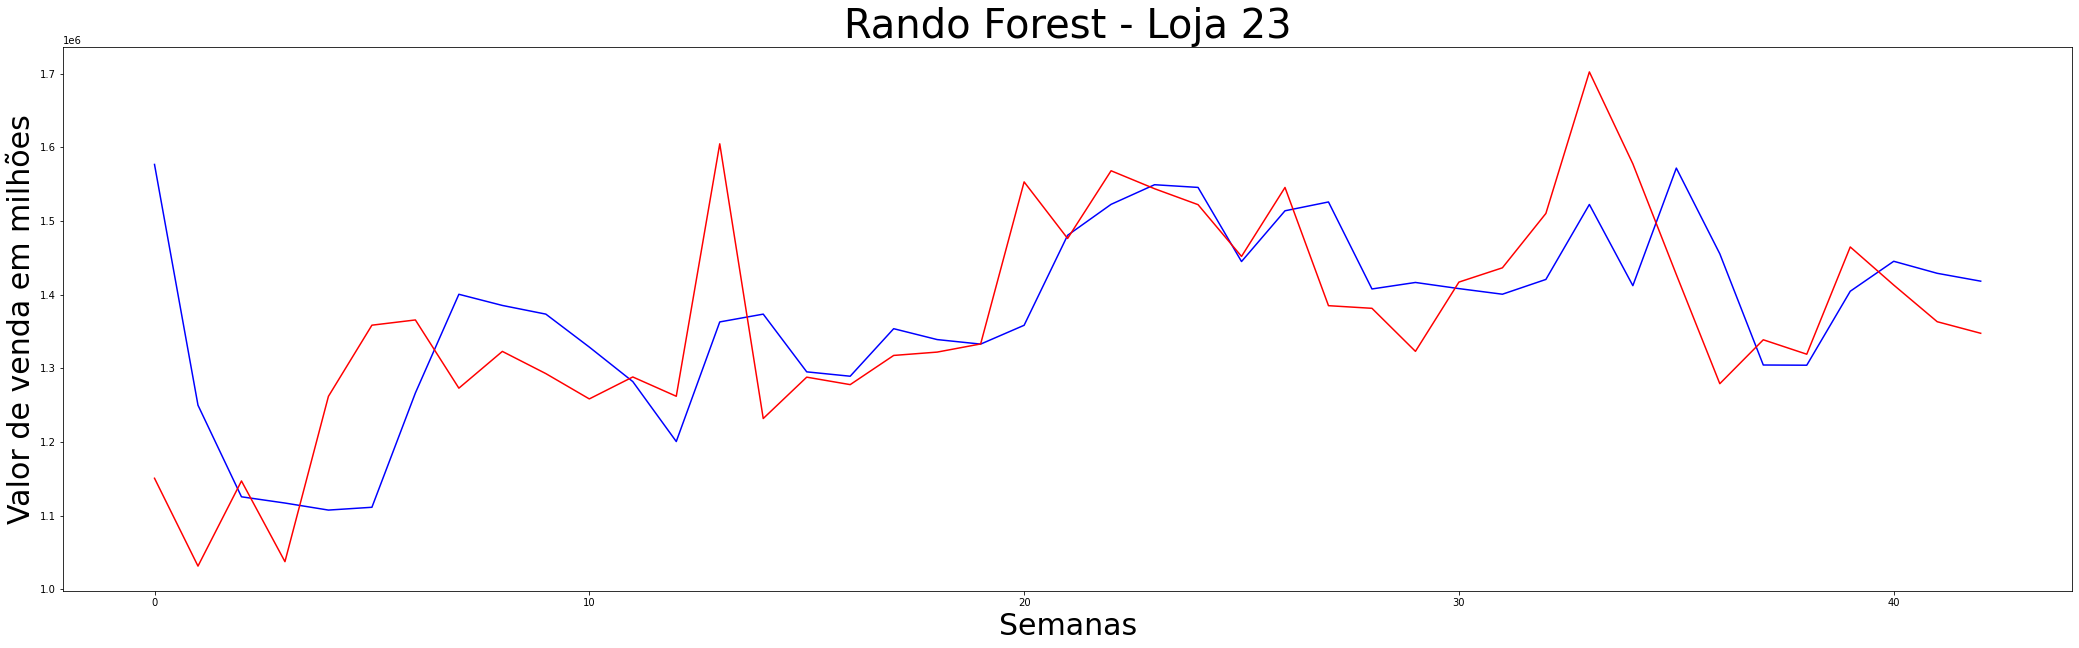

**************************************************
Resultados Loja 24:
91160.57996422947 114316.15542040479


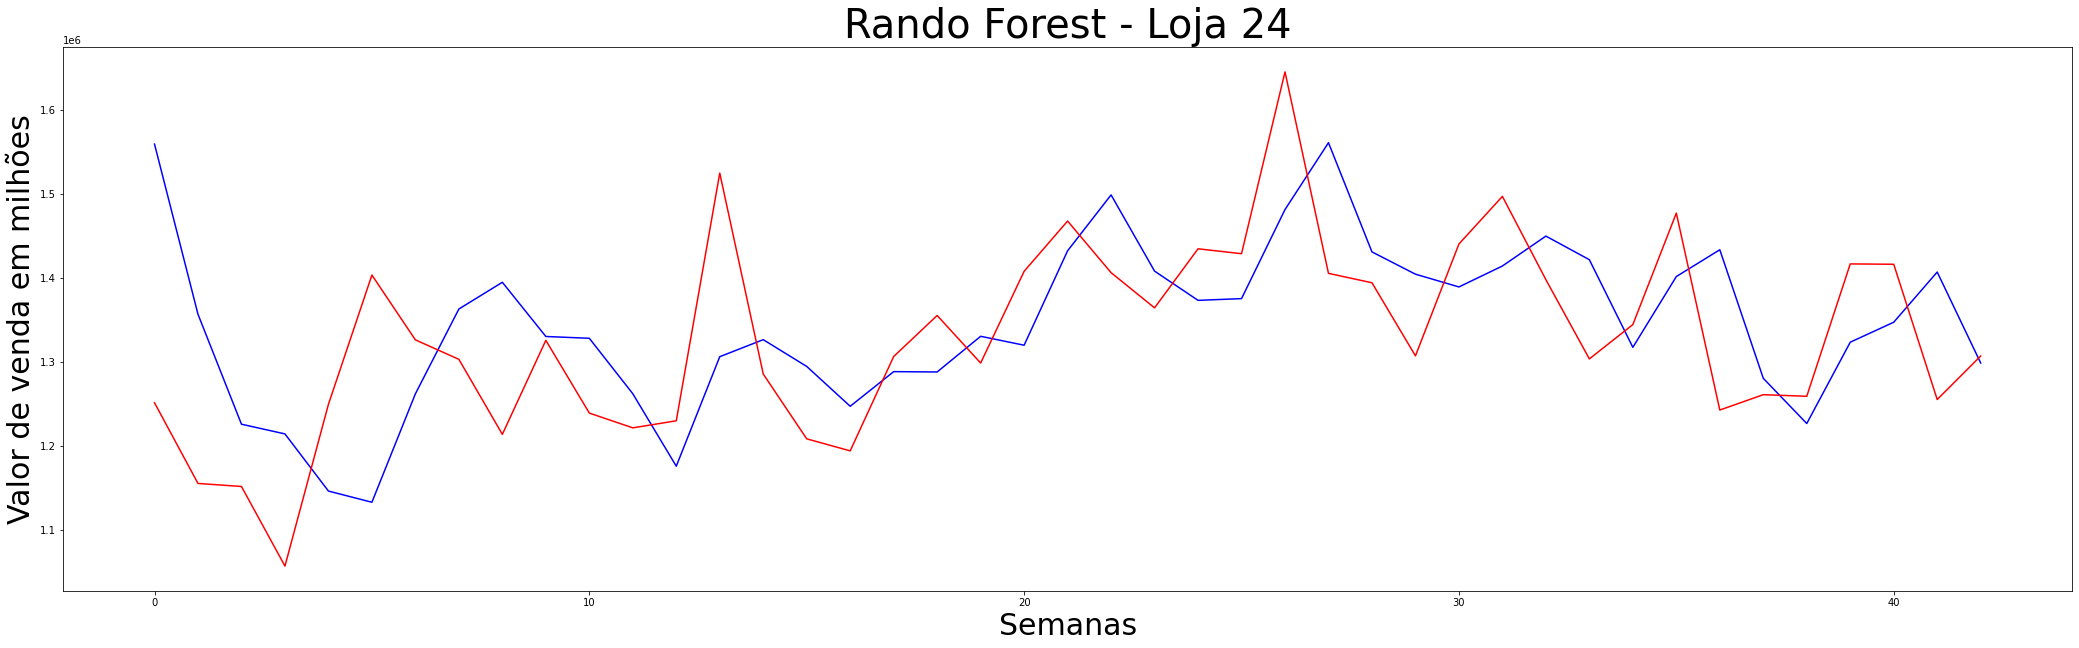

**************************************************
Resultados Loja 25:
35716.46242629382 47258.44485718104


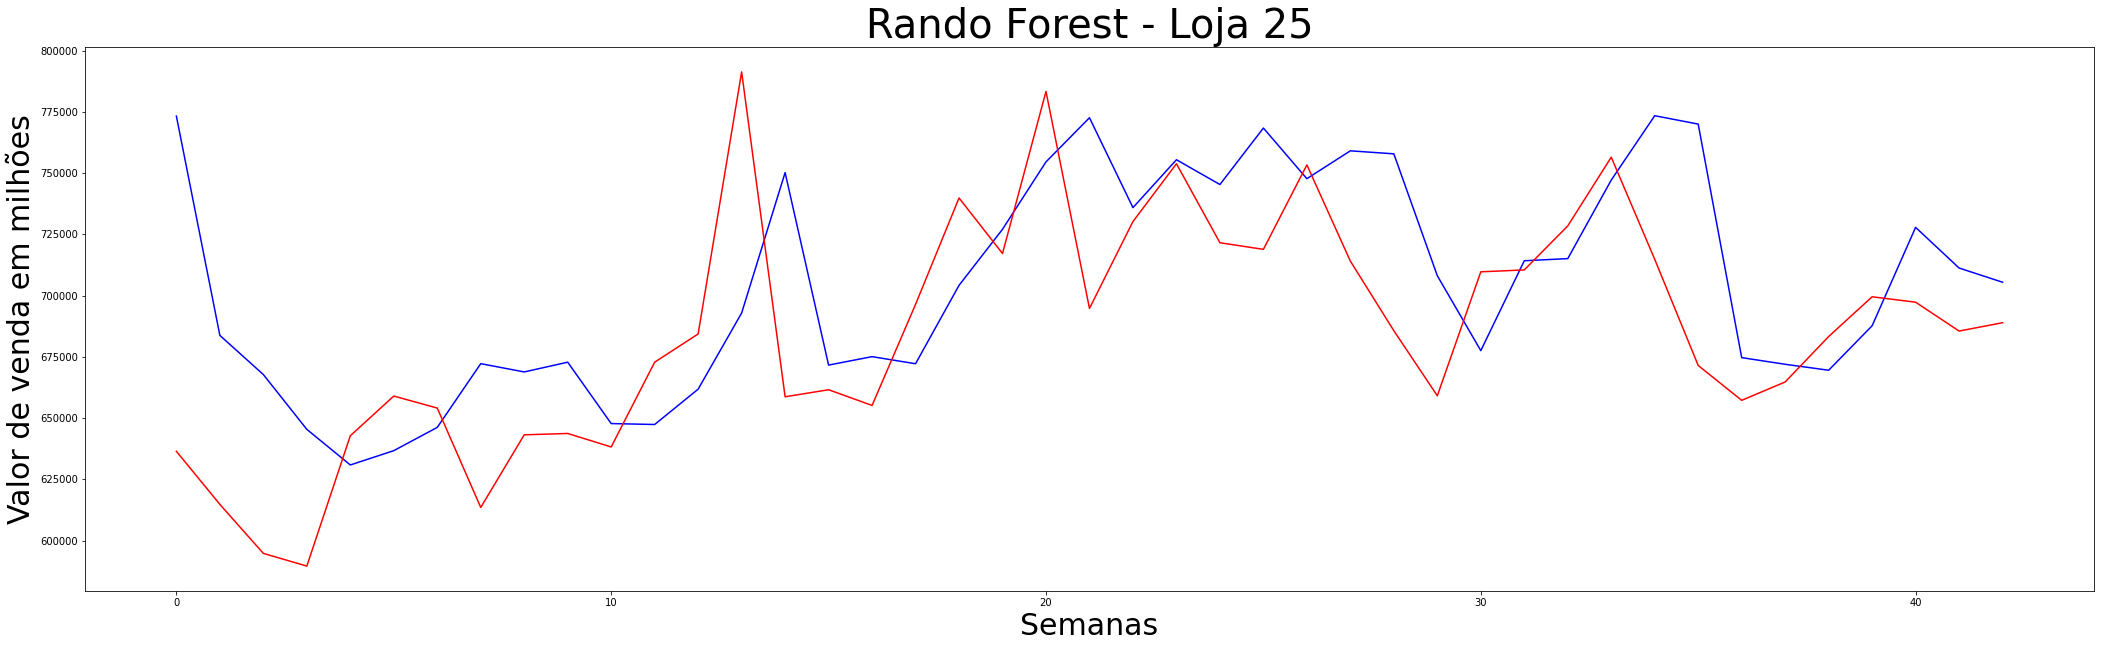

**************************************************
Resultados Loja 26:
61207.62790118578 77927.95629794452


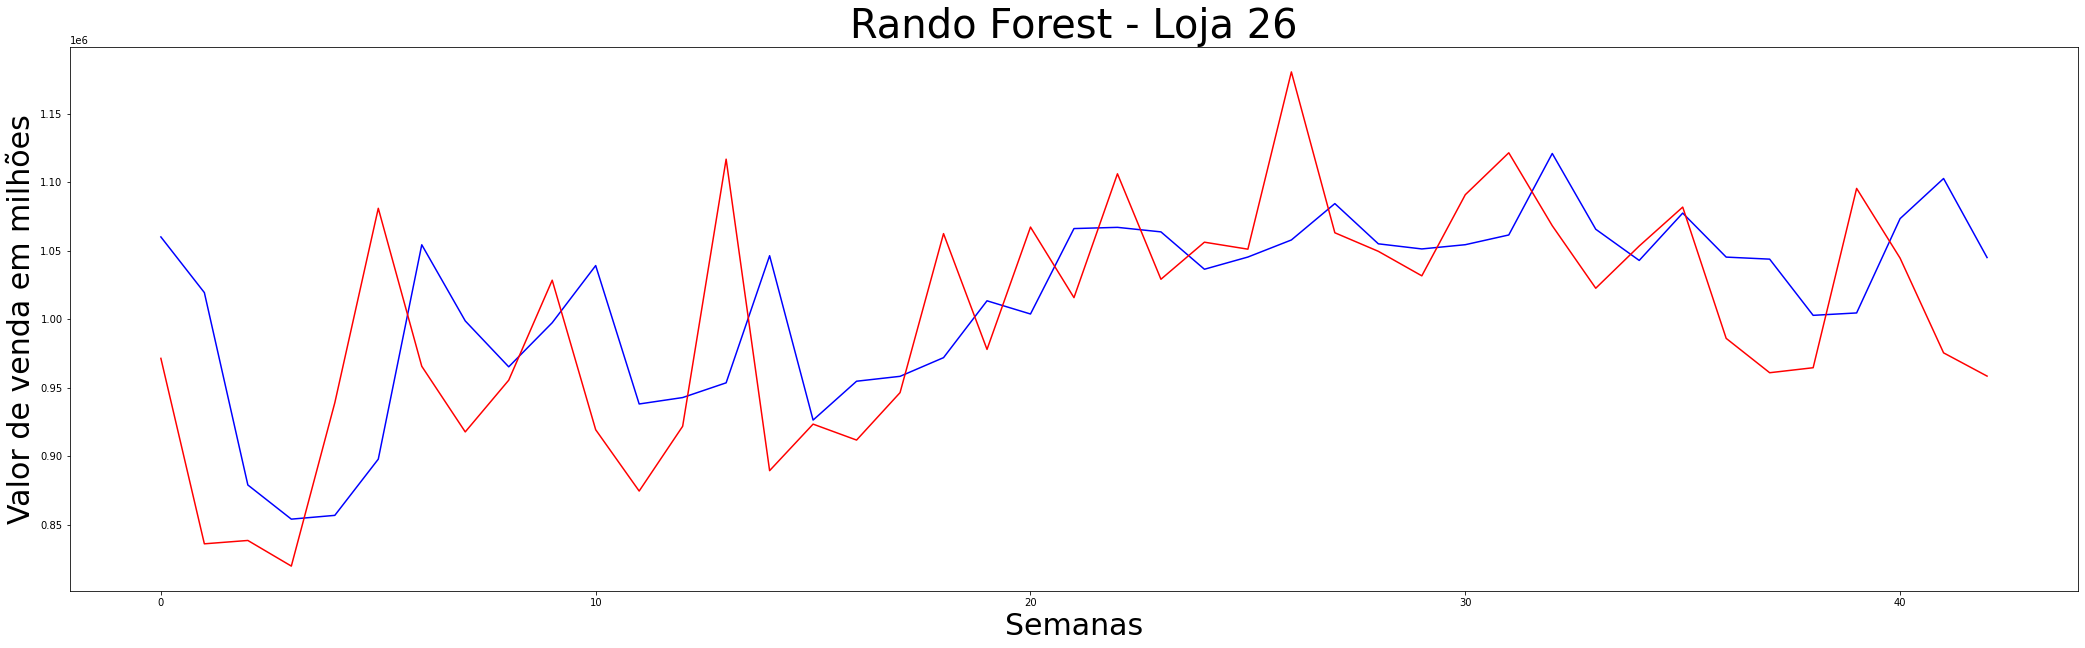

**************************************************
Resultados Loja 27:
90212.00953705059 121019.12300789887


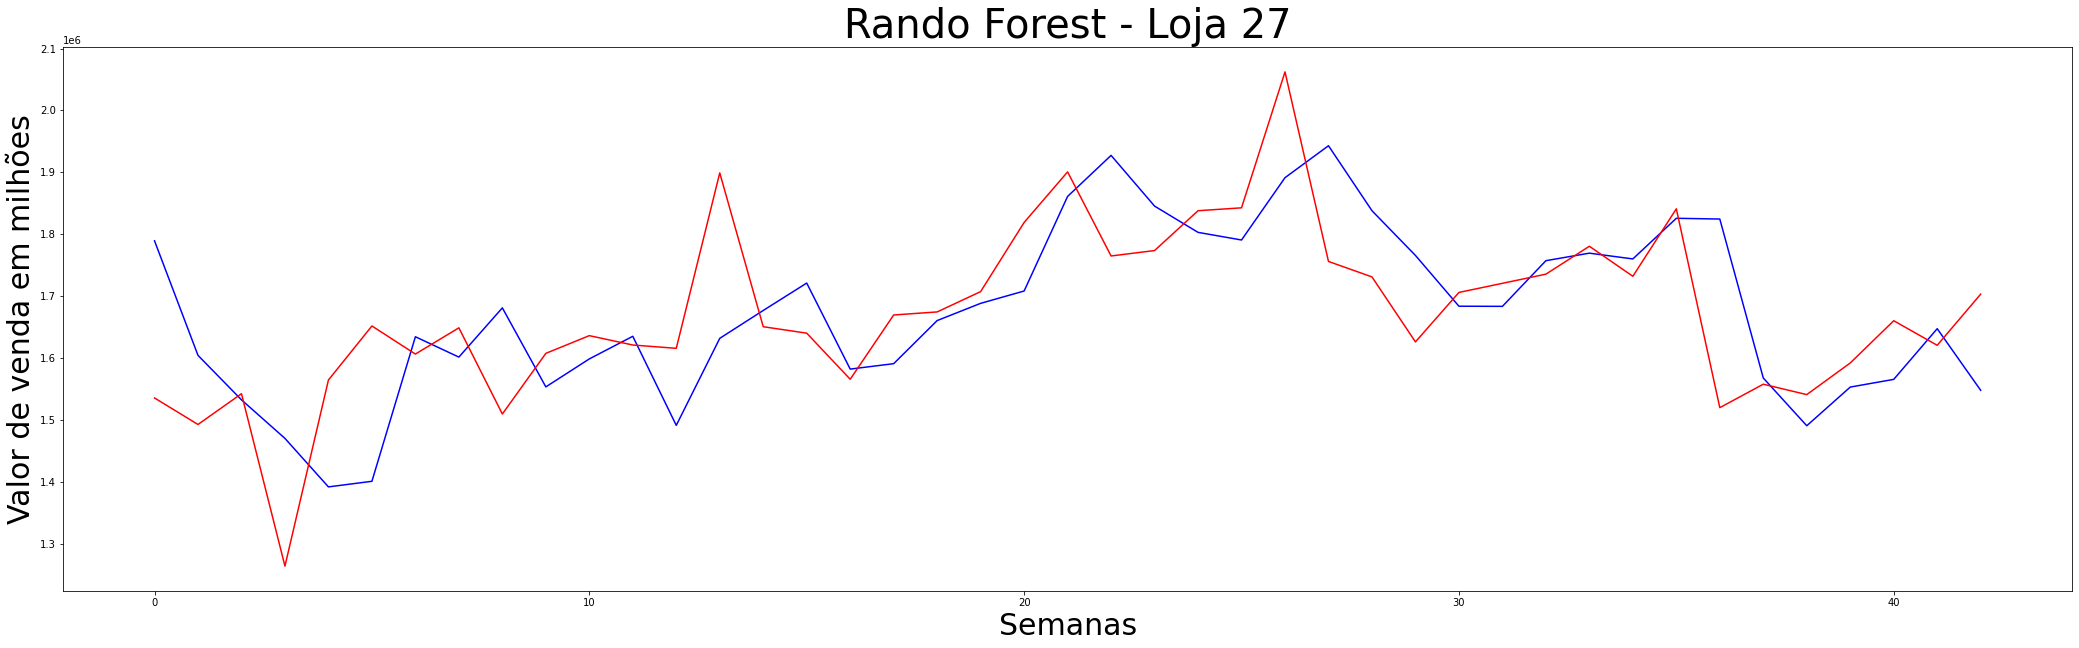

**************************************************
Resultados Loja 28:
117389.23403527476 142924.14398779933


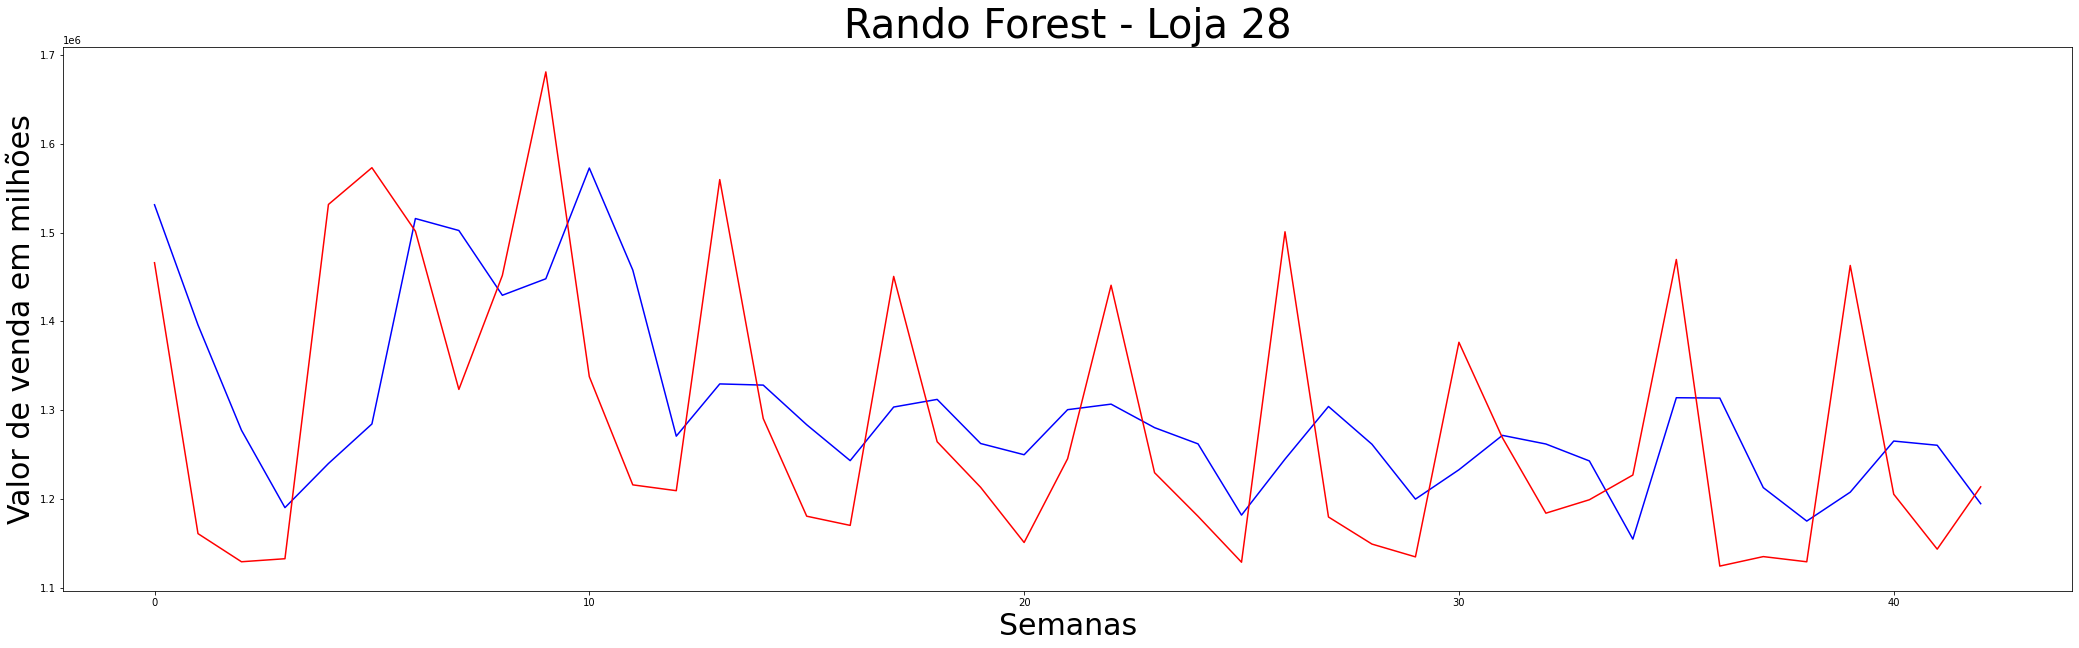

**************************************************
Resultados Loja 29:
36718.69314772834 52919.44553653313


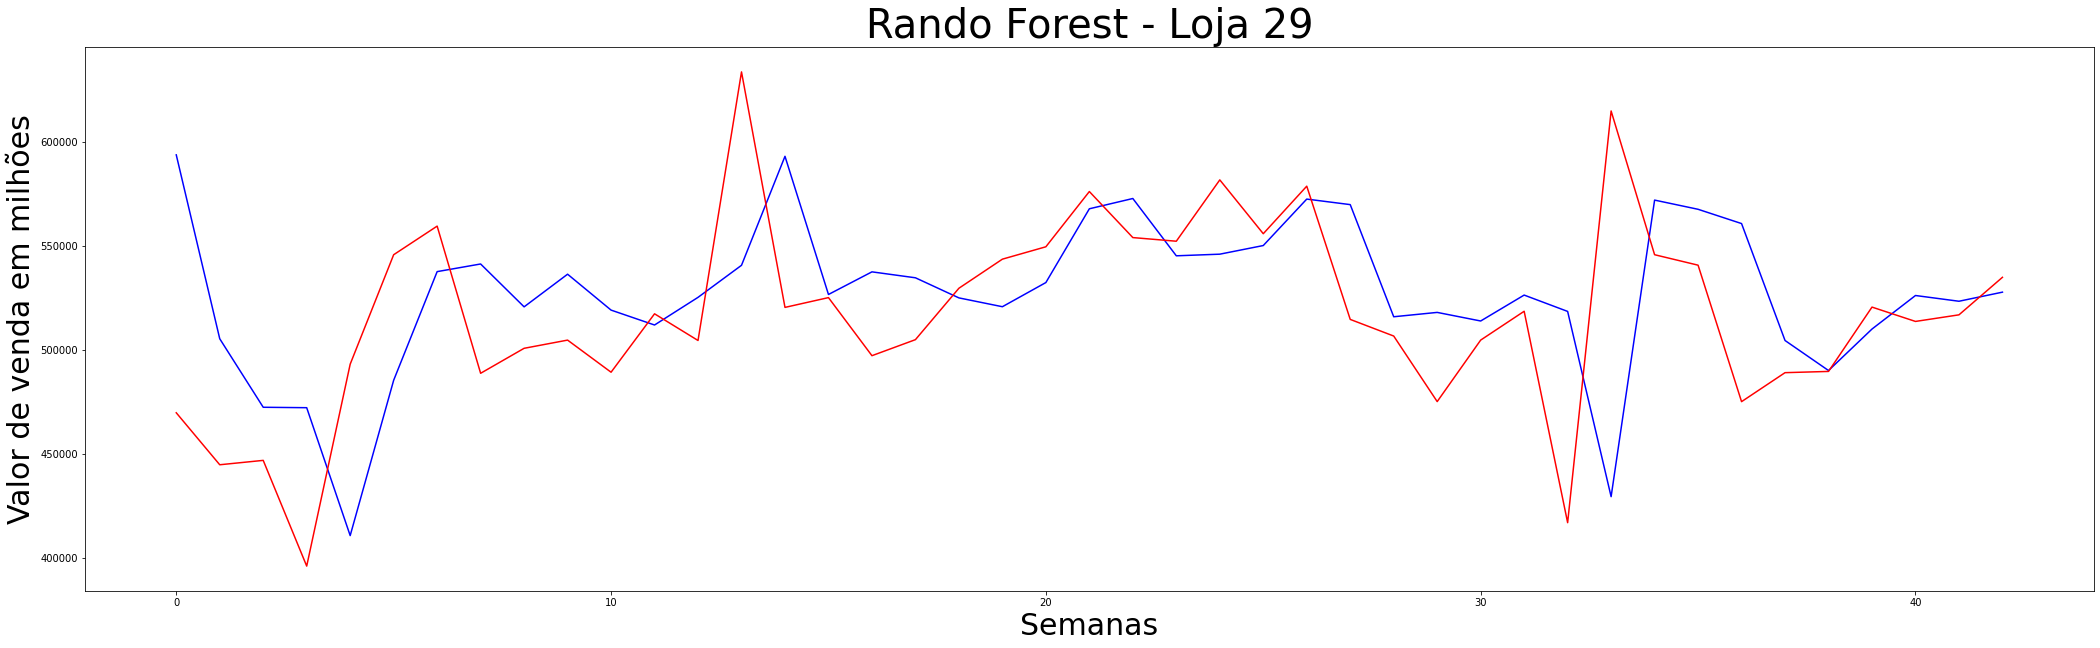

**************************************************
Resultados Loja 30:
12287.874466415122 15698.99855933333


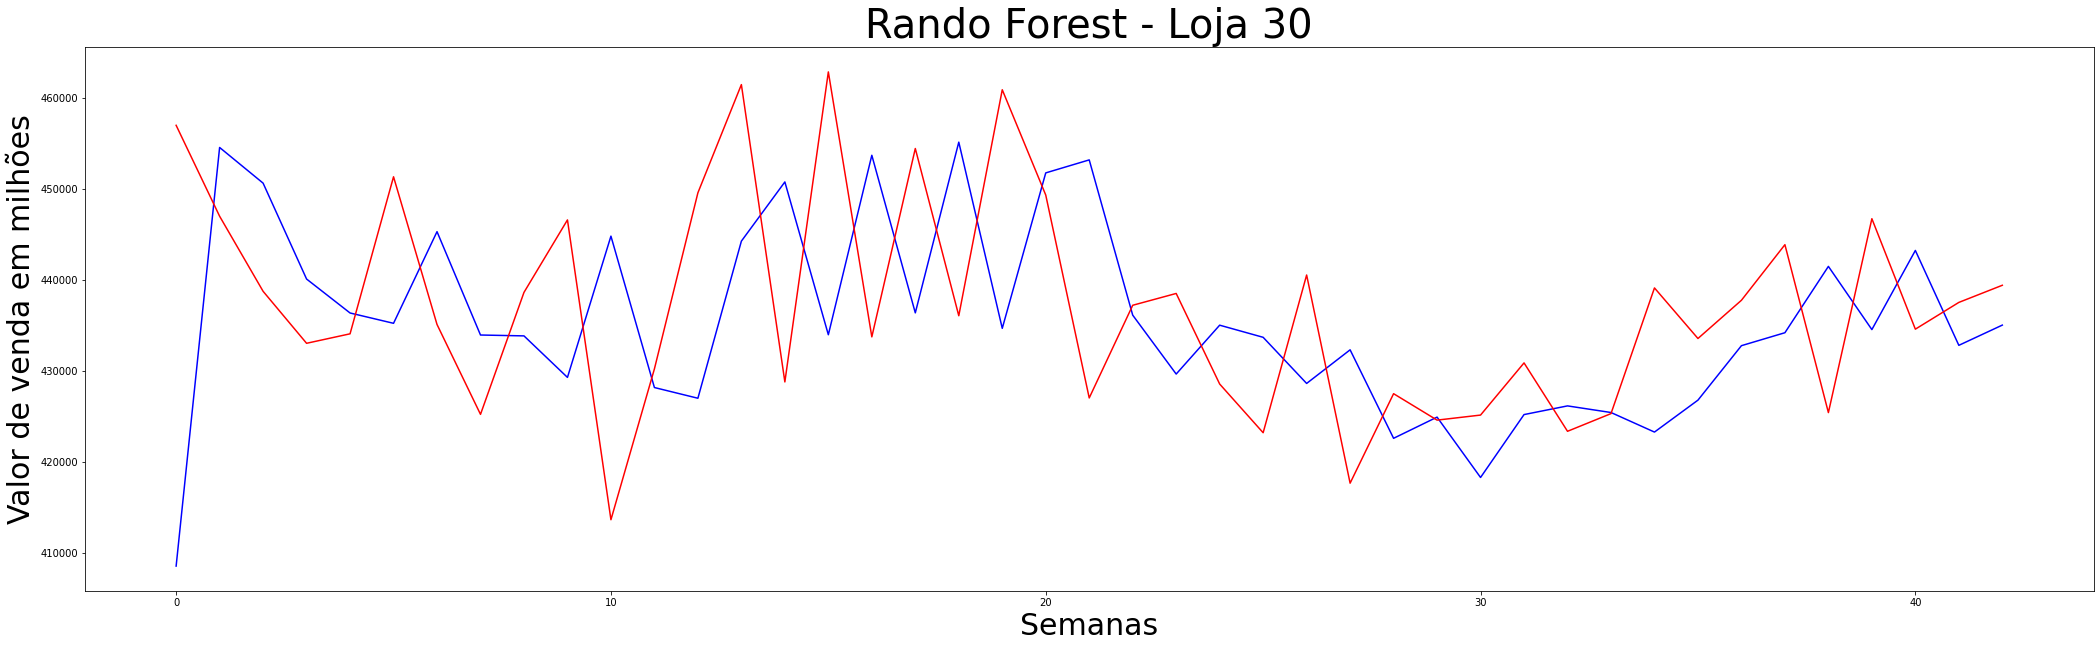

**************************************************
Resultados Loja 31:
53539.4498670675 71926.86794302672


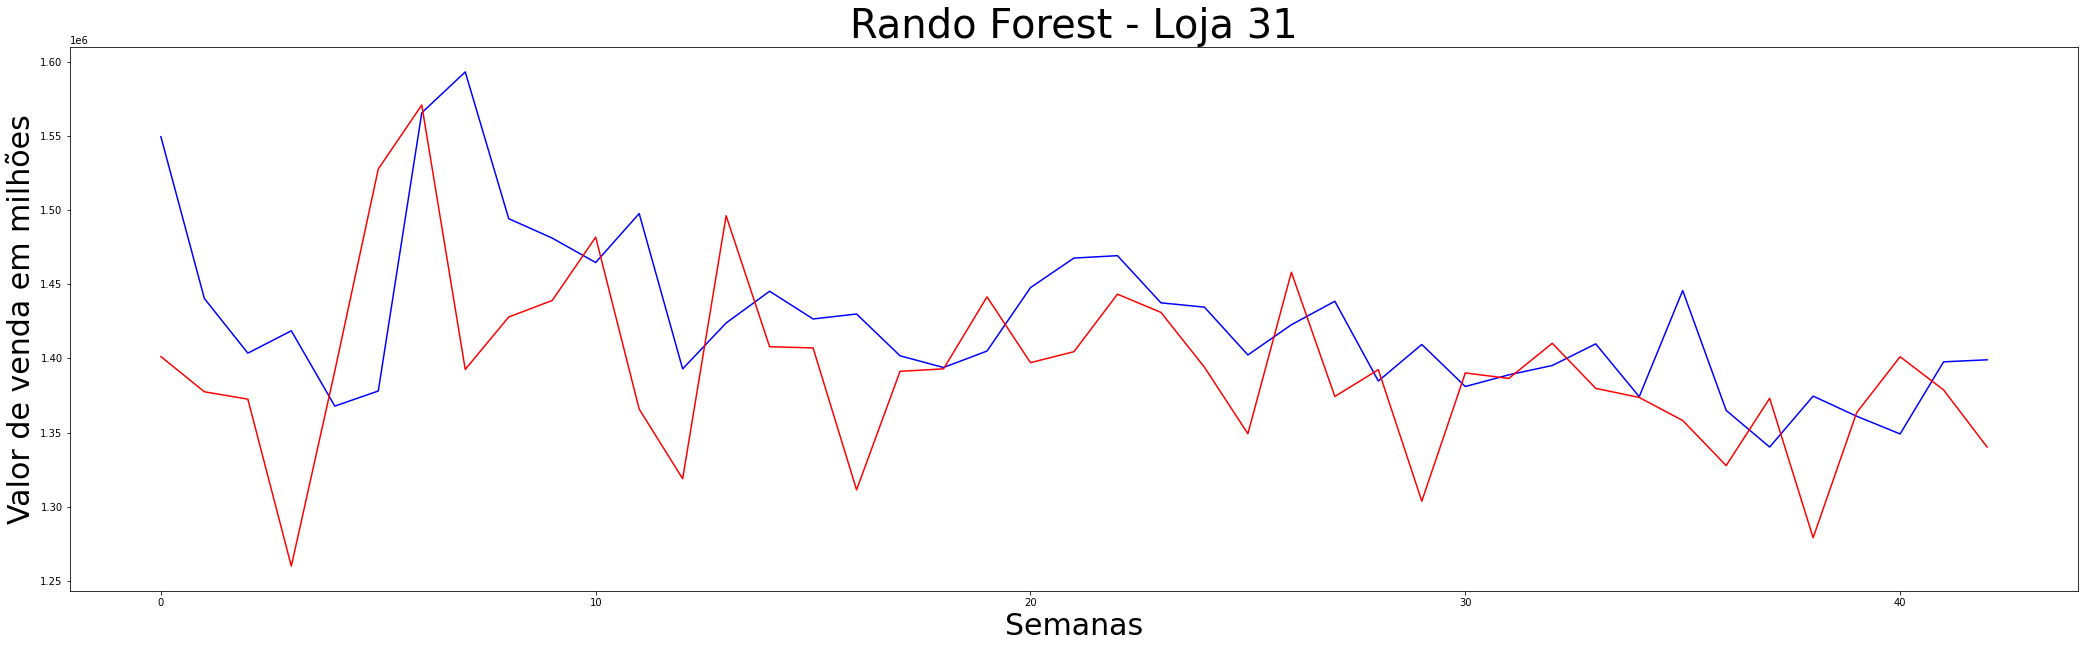

**************************************************
Resultados Loja 32:
48768.08749694869 66660.92267715209


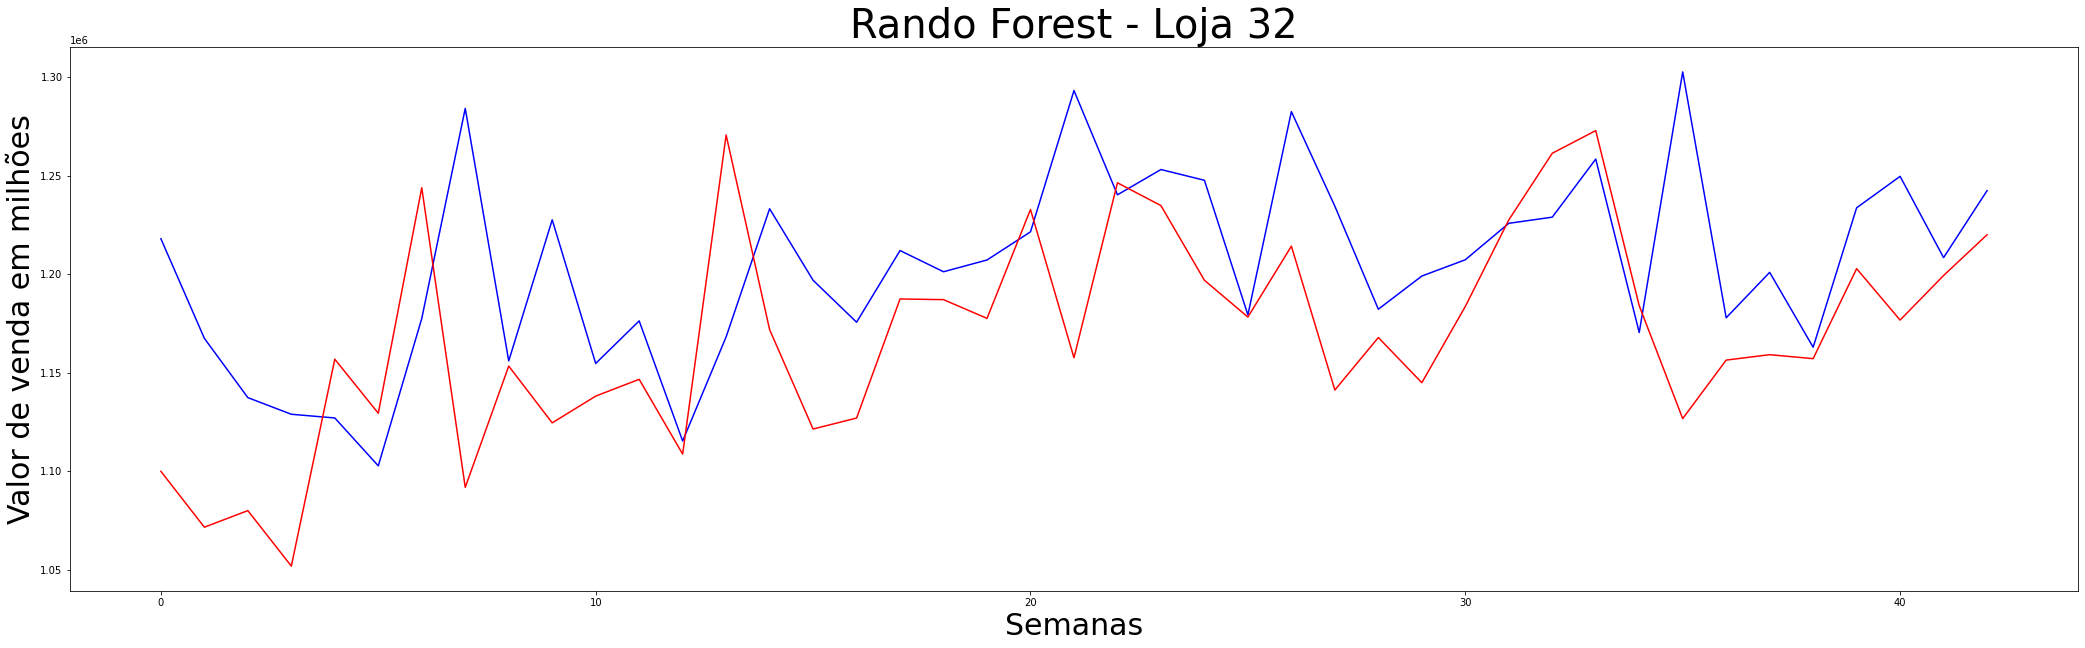

**************************************************
Resultados Loja 33:
15475.287377687067 18961.595980787257


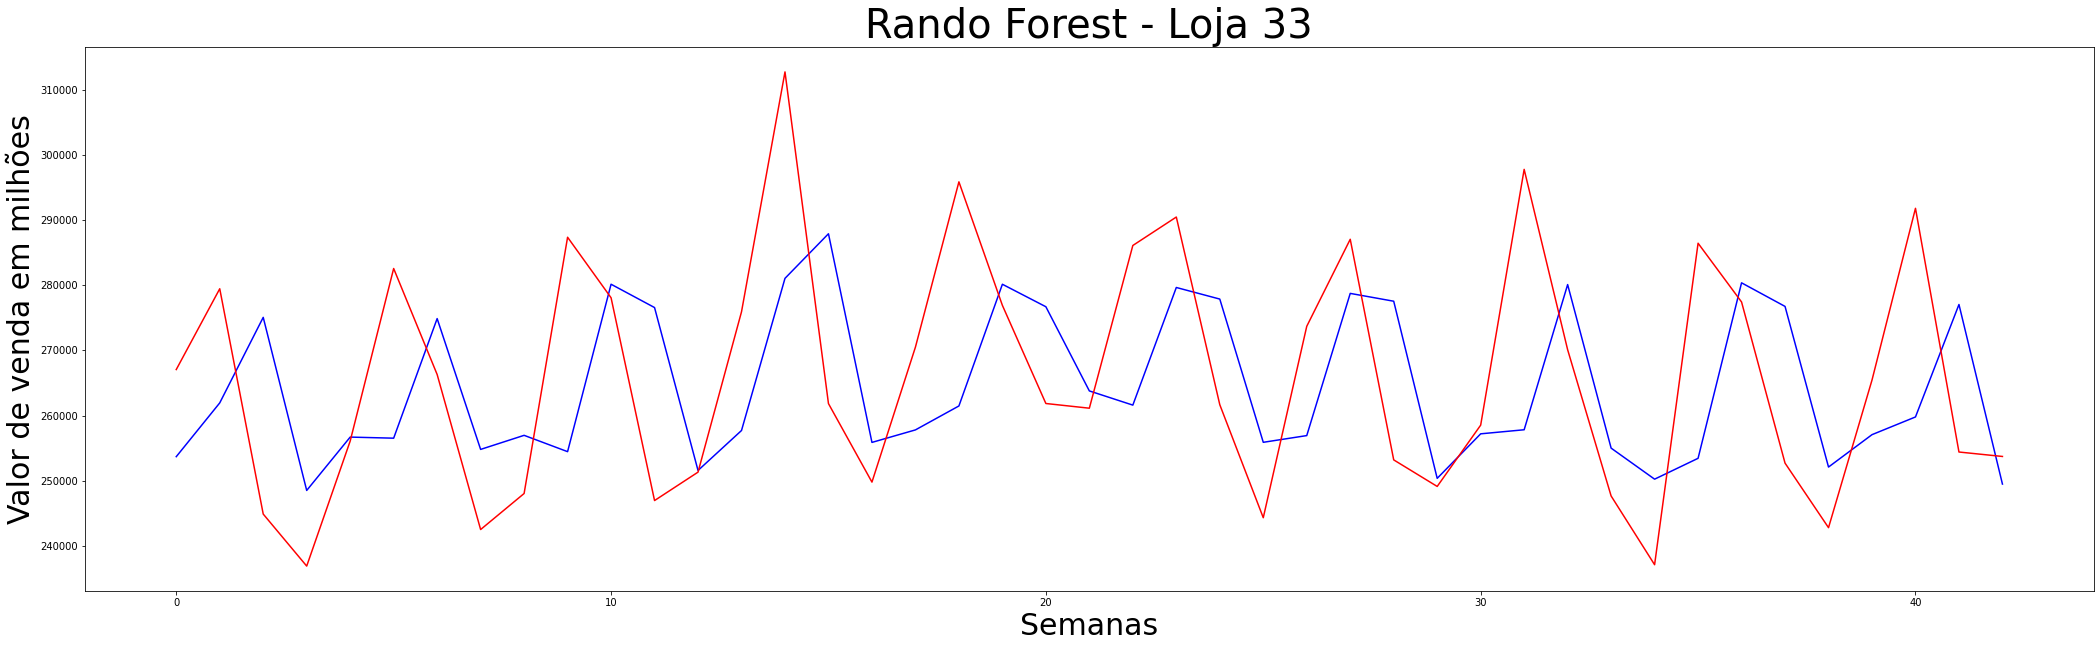

**************************************************
Resultados Loja 34:
37818.12389883549 47339.80730593026


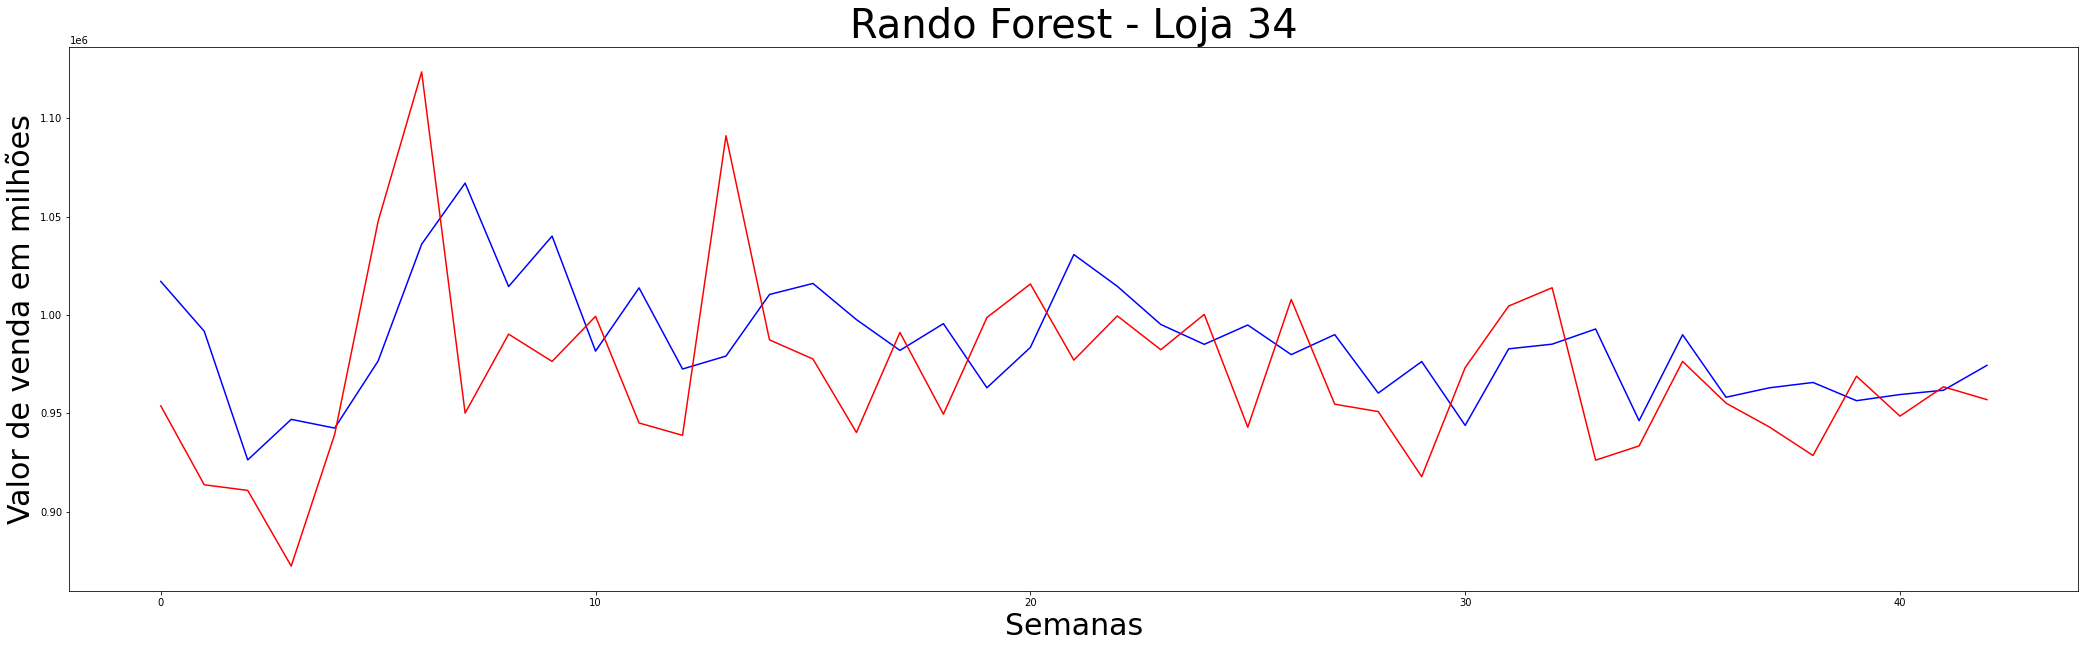

**************************************************
Resultados Loja 35:
51888.68422459108 77481.94764235243


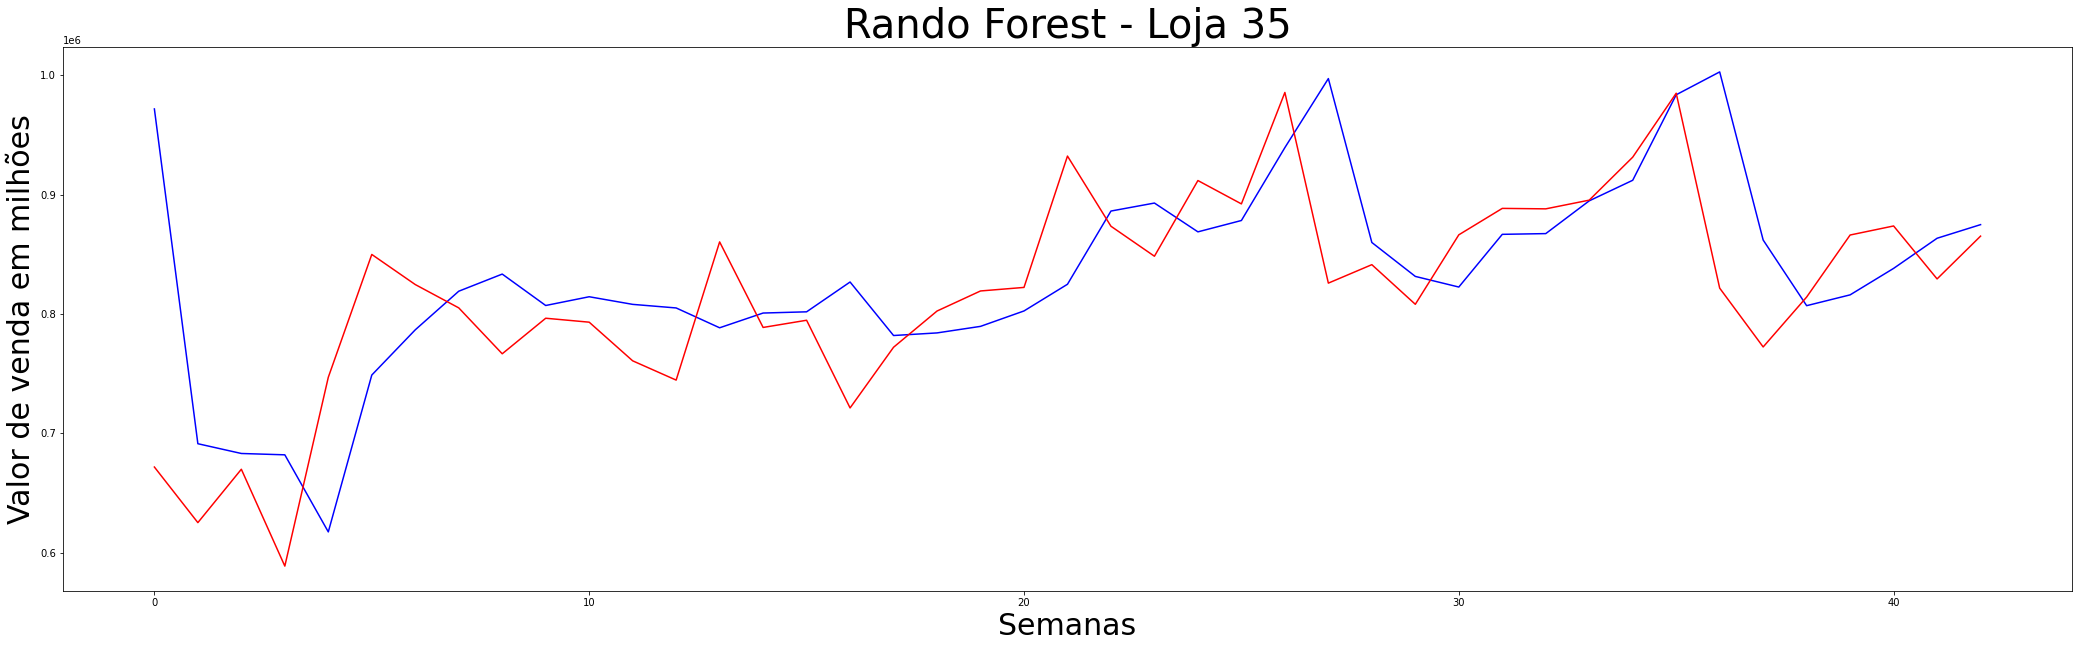

**************************************************
Resultados Loja 36:
14309.736923854043 18164.299881559687


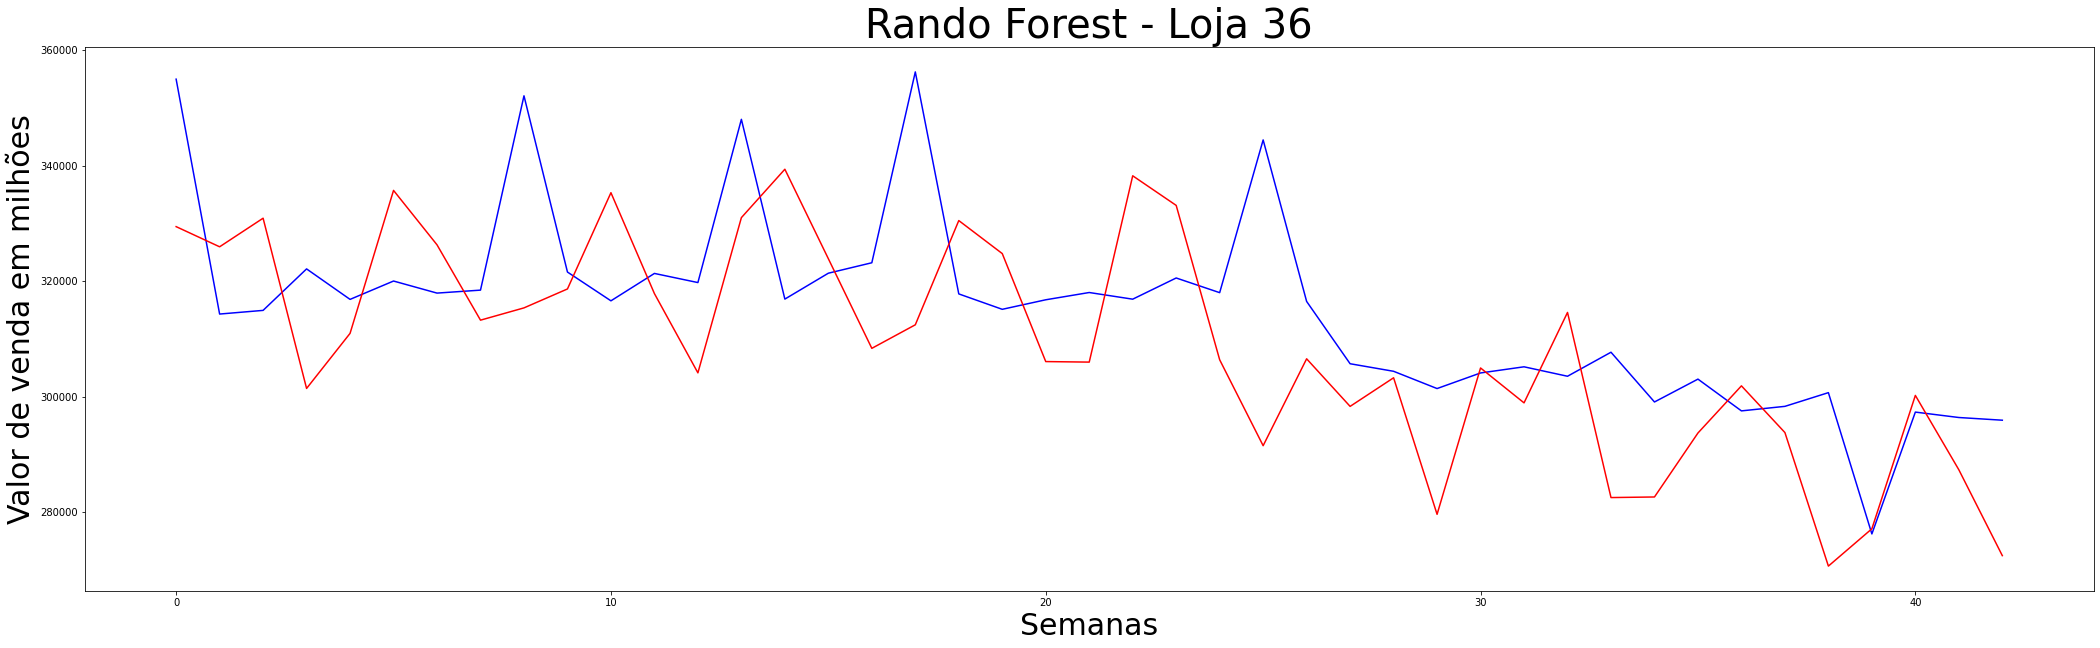

**************************************************
Resultados Loja 37:
14851.267122959234 19738.126251944435


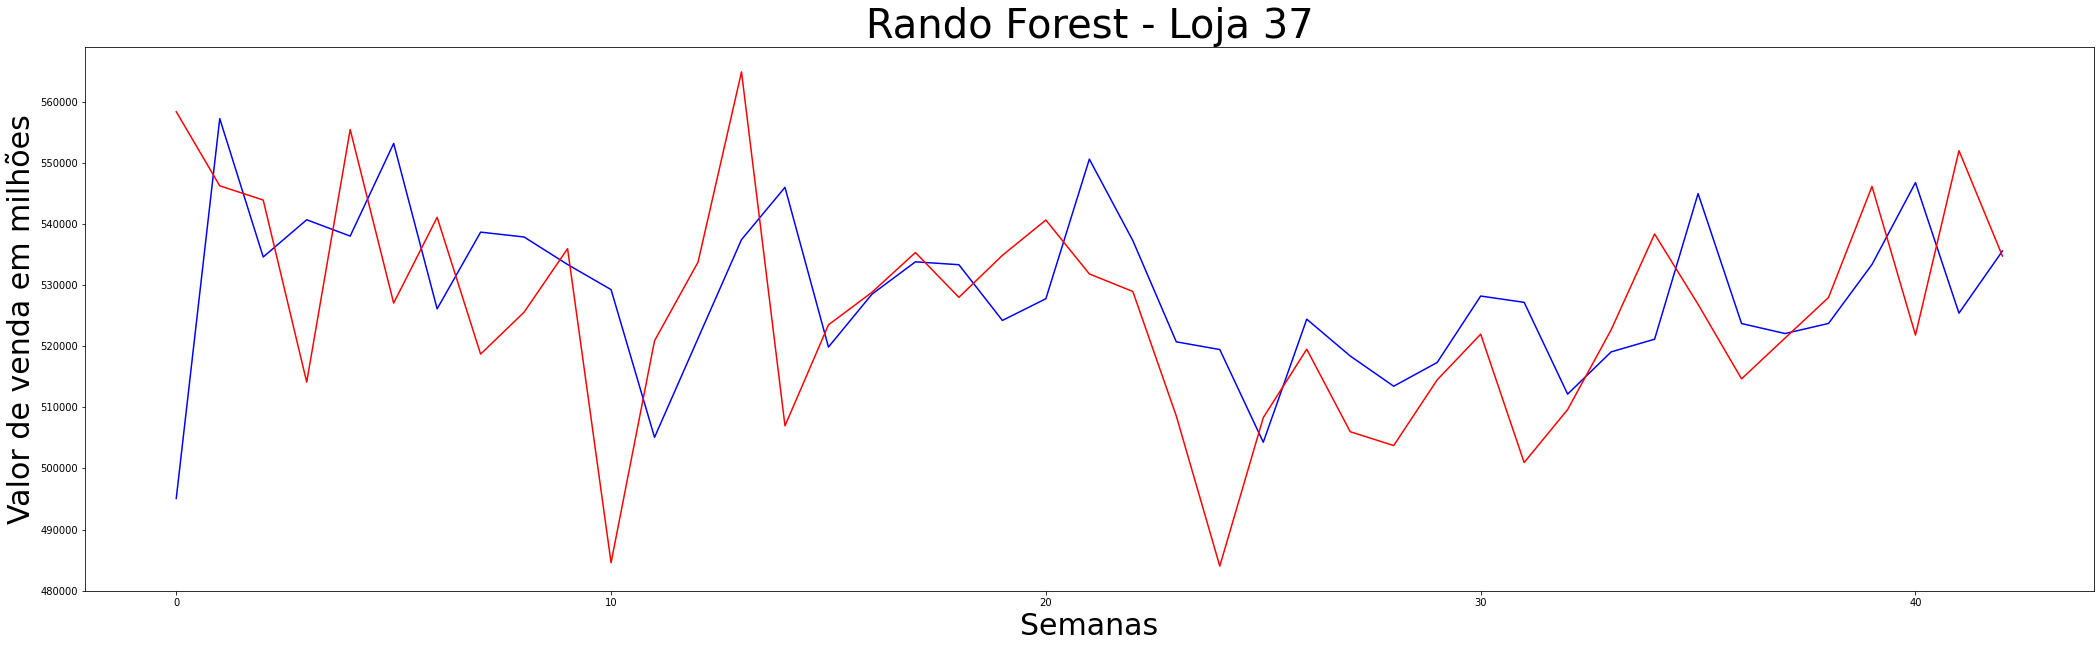

**************************************************
Resultados Loja 38:
34812.370900077454 41757.93037399609


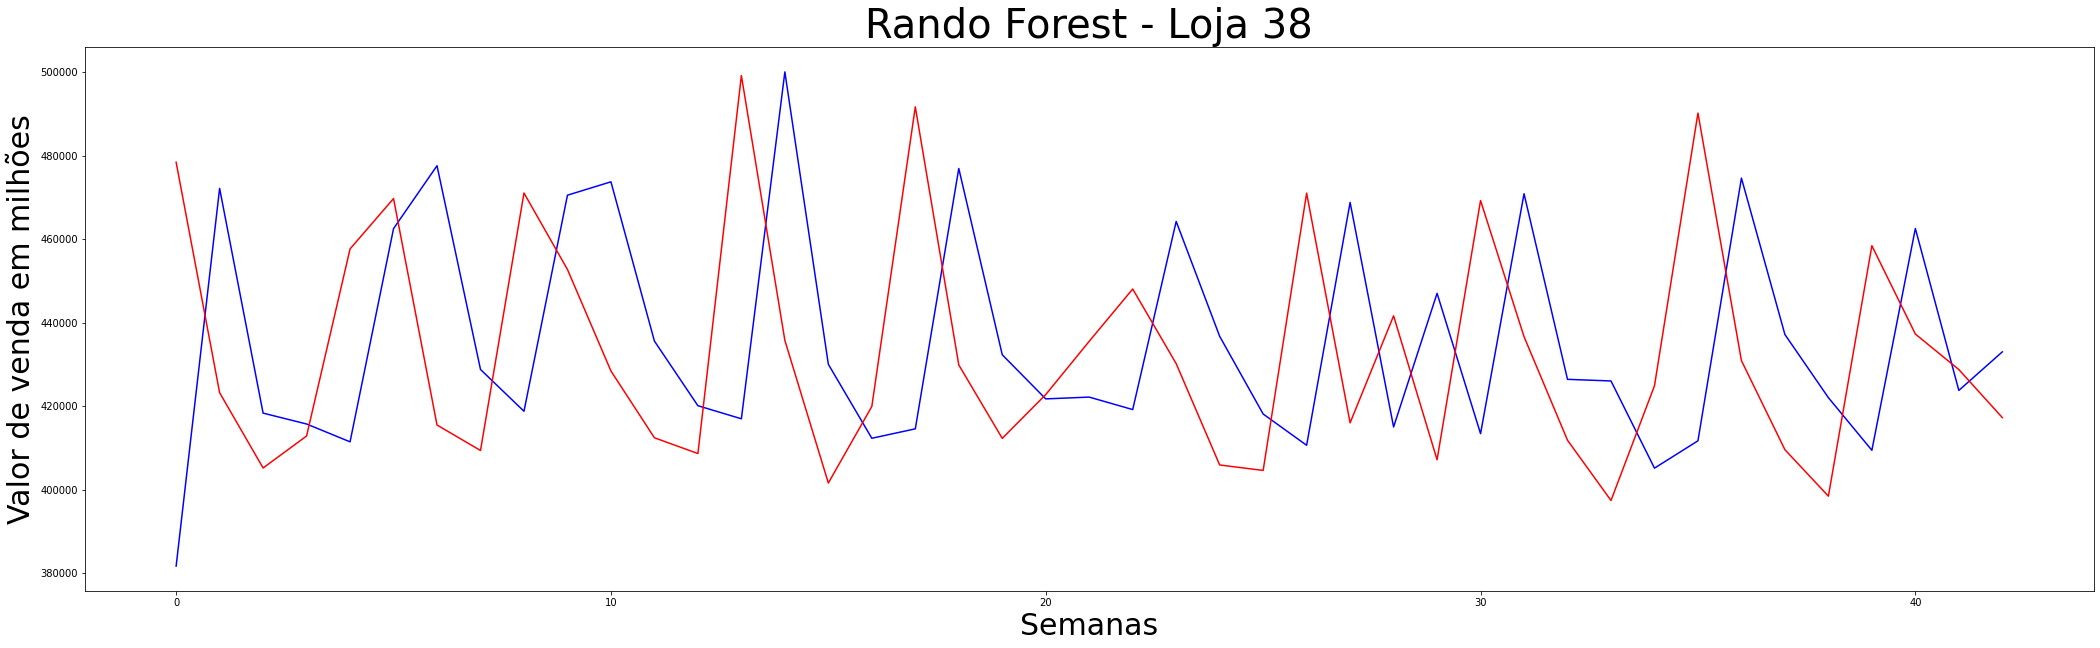

**************************************************
Resultados Loja 39:
74024.37986972294 90522.57884216157


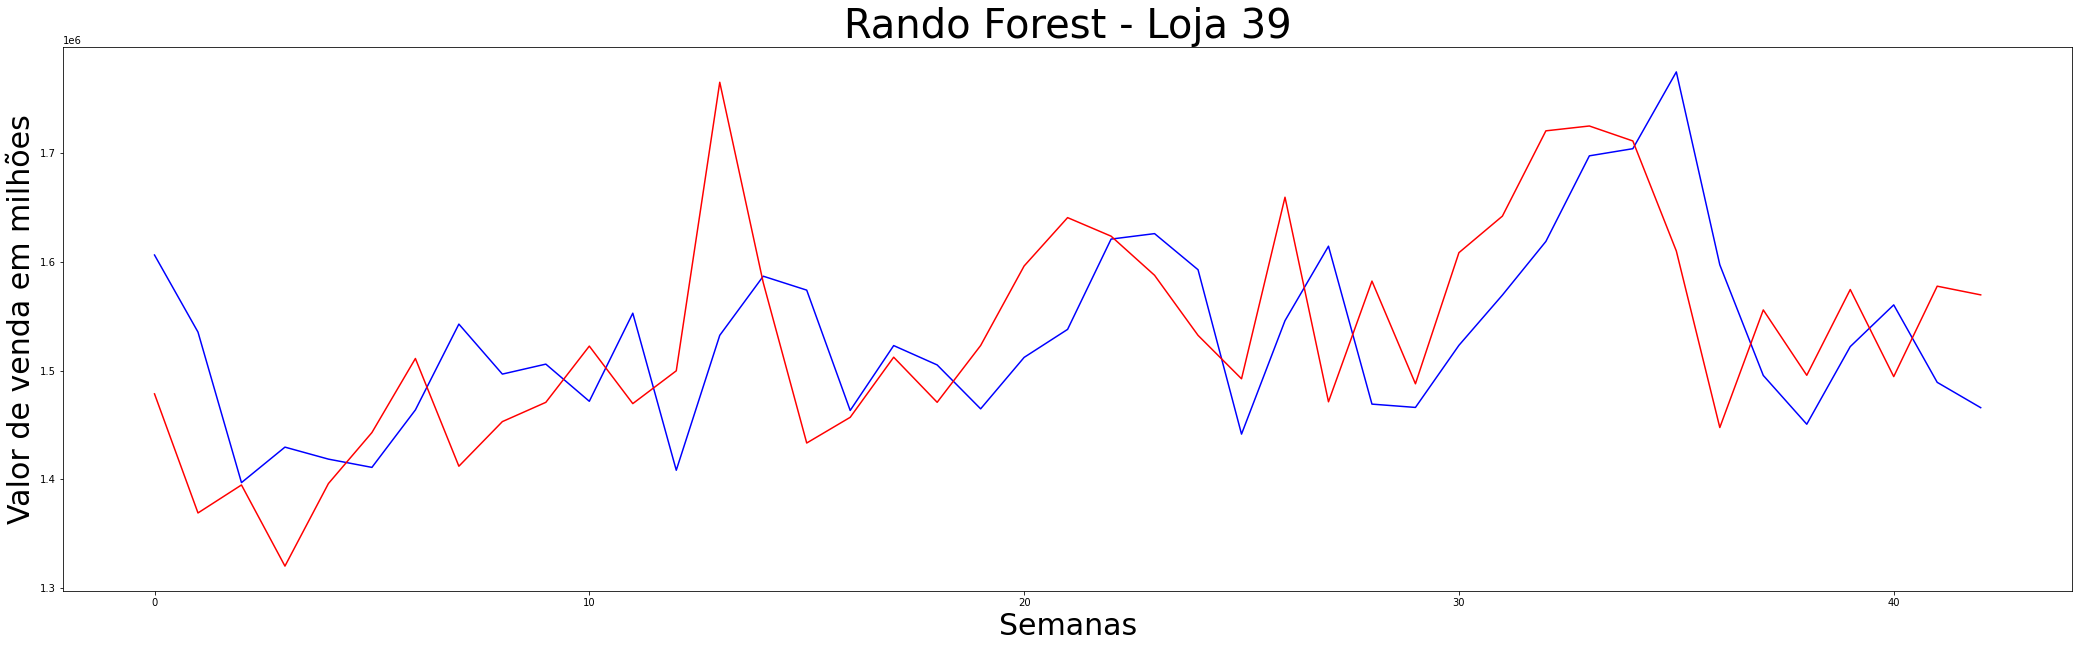

**************************************************
Resultados Loja 40:
65307.57366121031 84971.2585675927


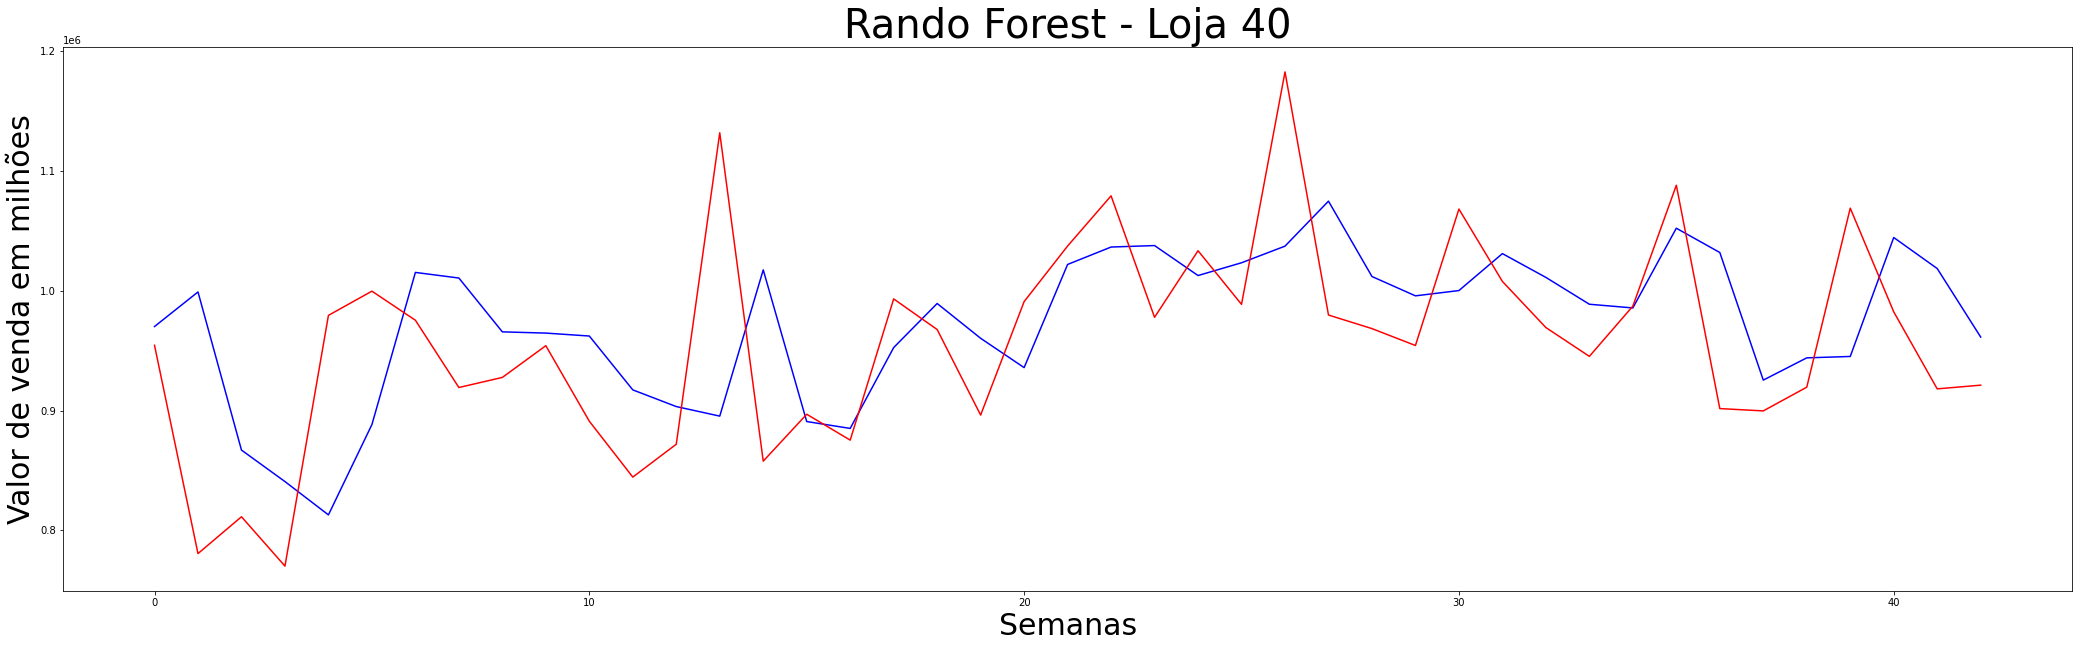

**************************************************
Resultados Loja 41:
67655.05771660207 90372.06728620594


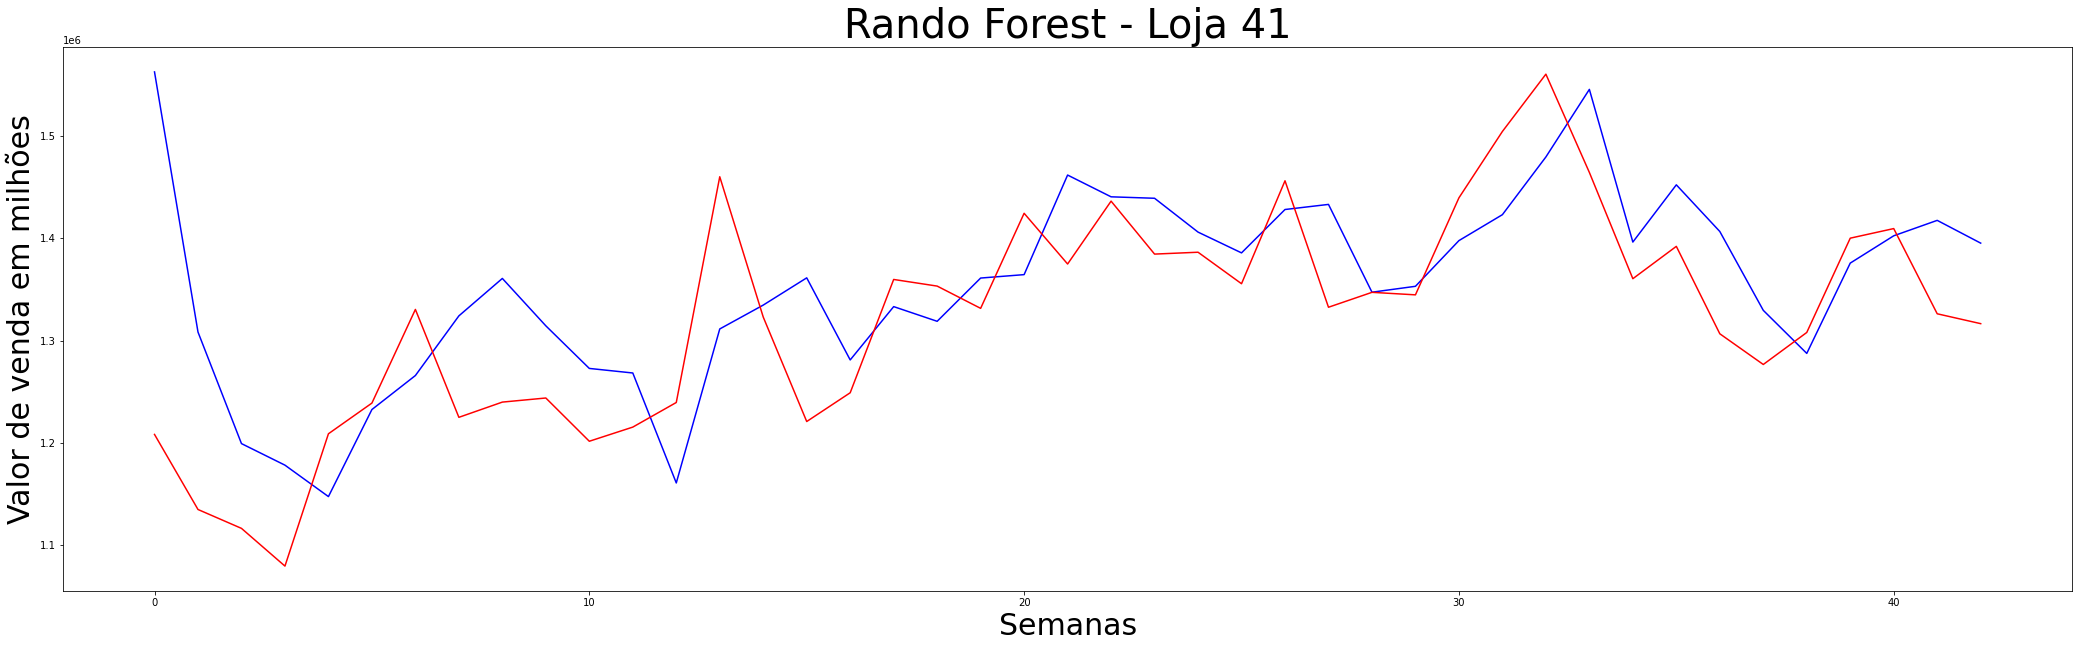

**************************************************
Resultados Loja 42:
40636.61079992431 48640.72172239277


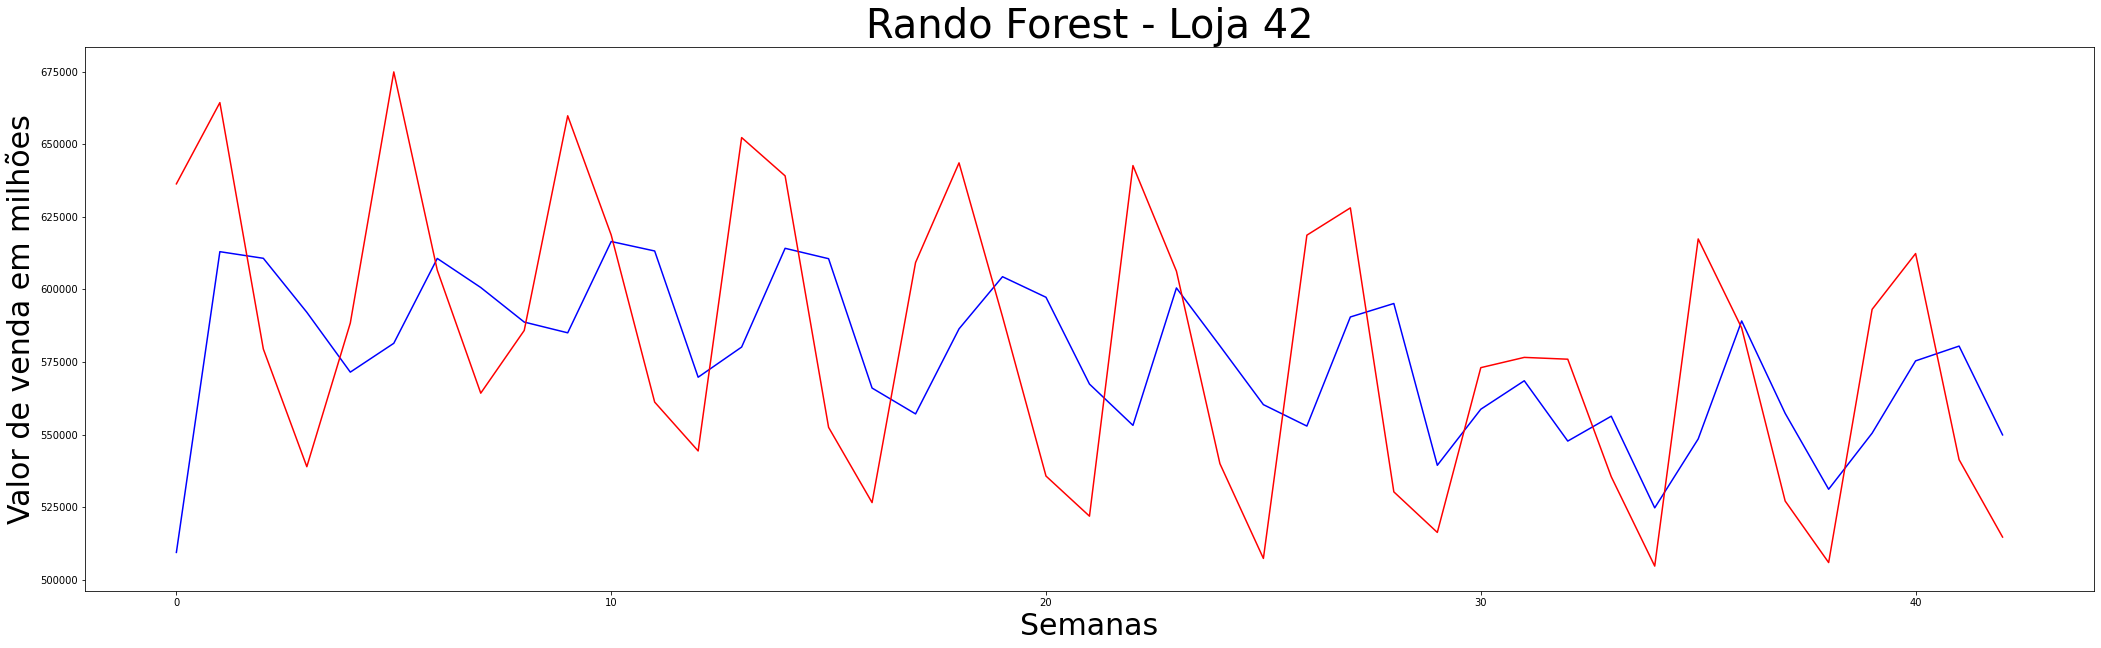

**************************************************
Resultados Loja 43:
28744.53946461692 36603.35567273057


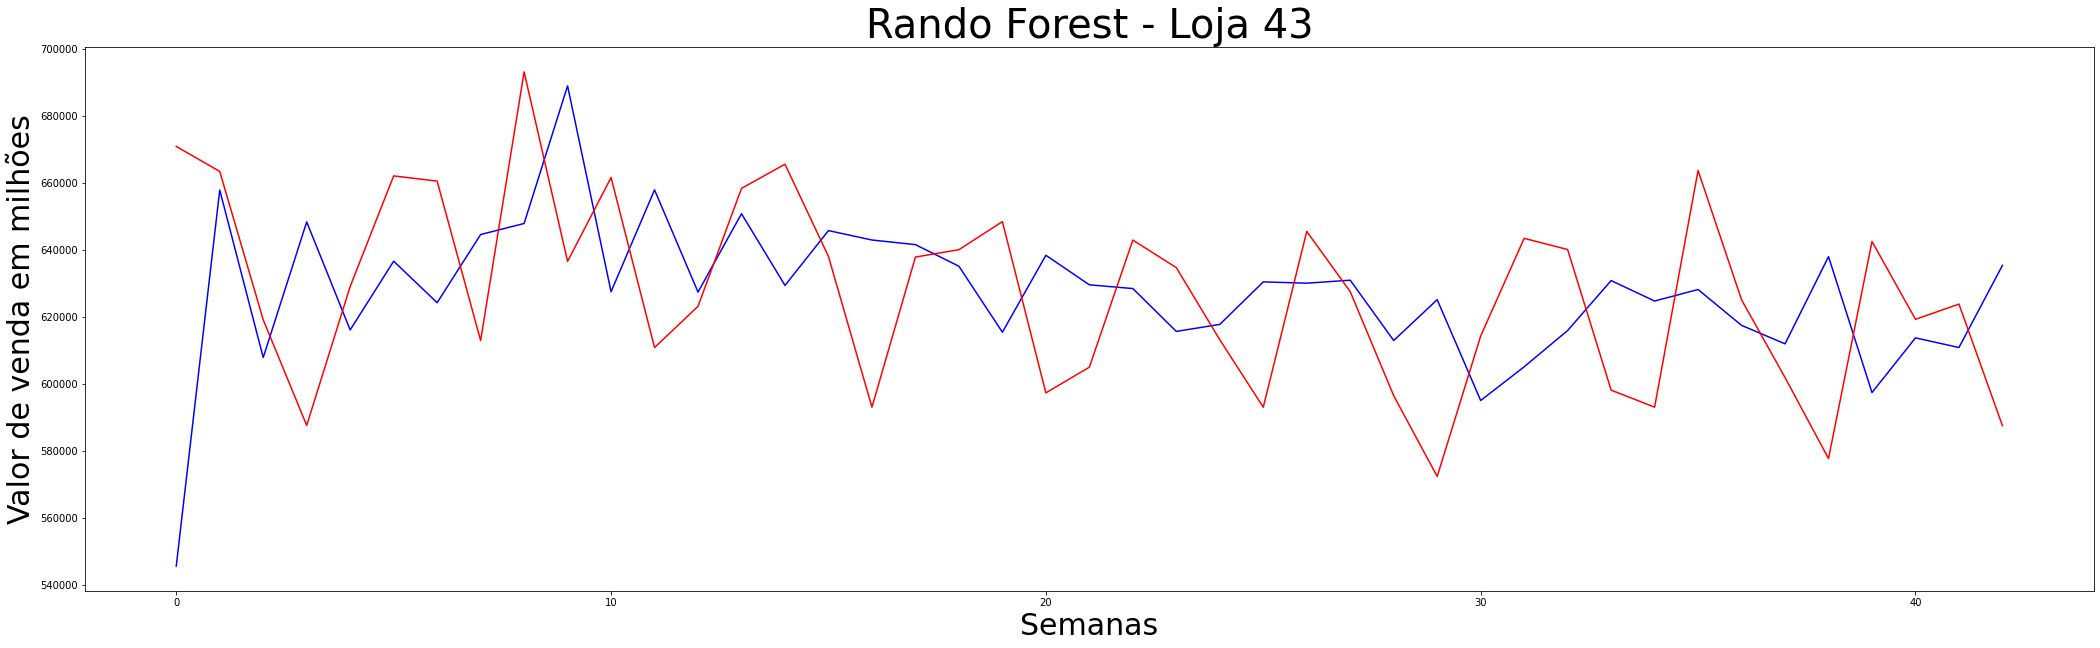

**************************************************
Resultados Loja 44:
15723.979383595164 19149.15012895948


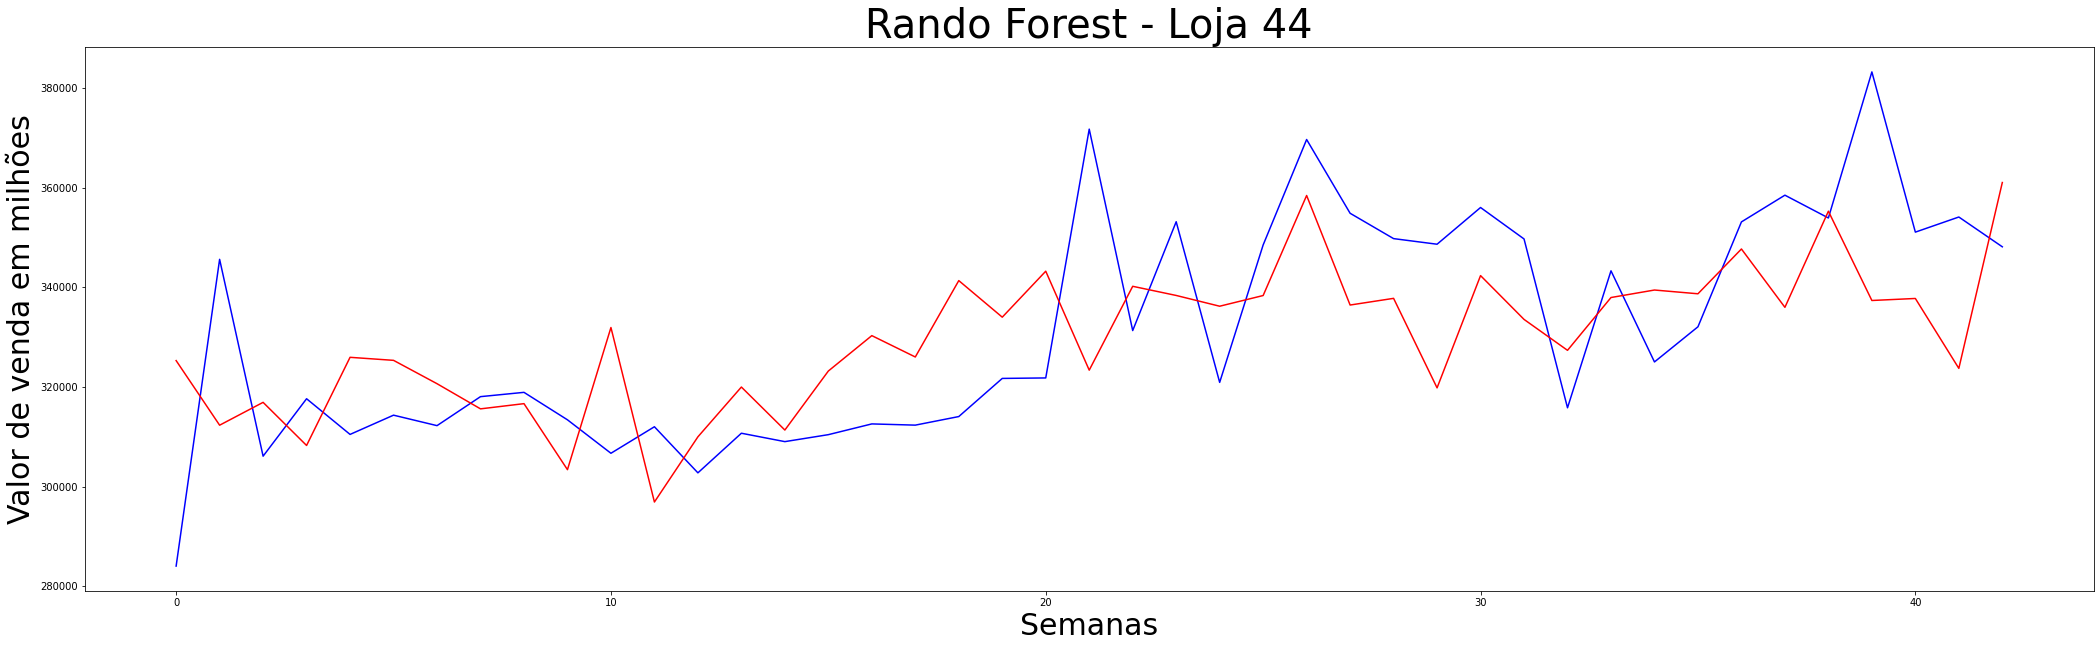

**************************************************
Resultados Loja 45:
46072.67525397474 64530.71443116465


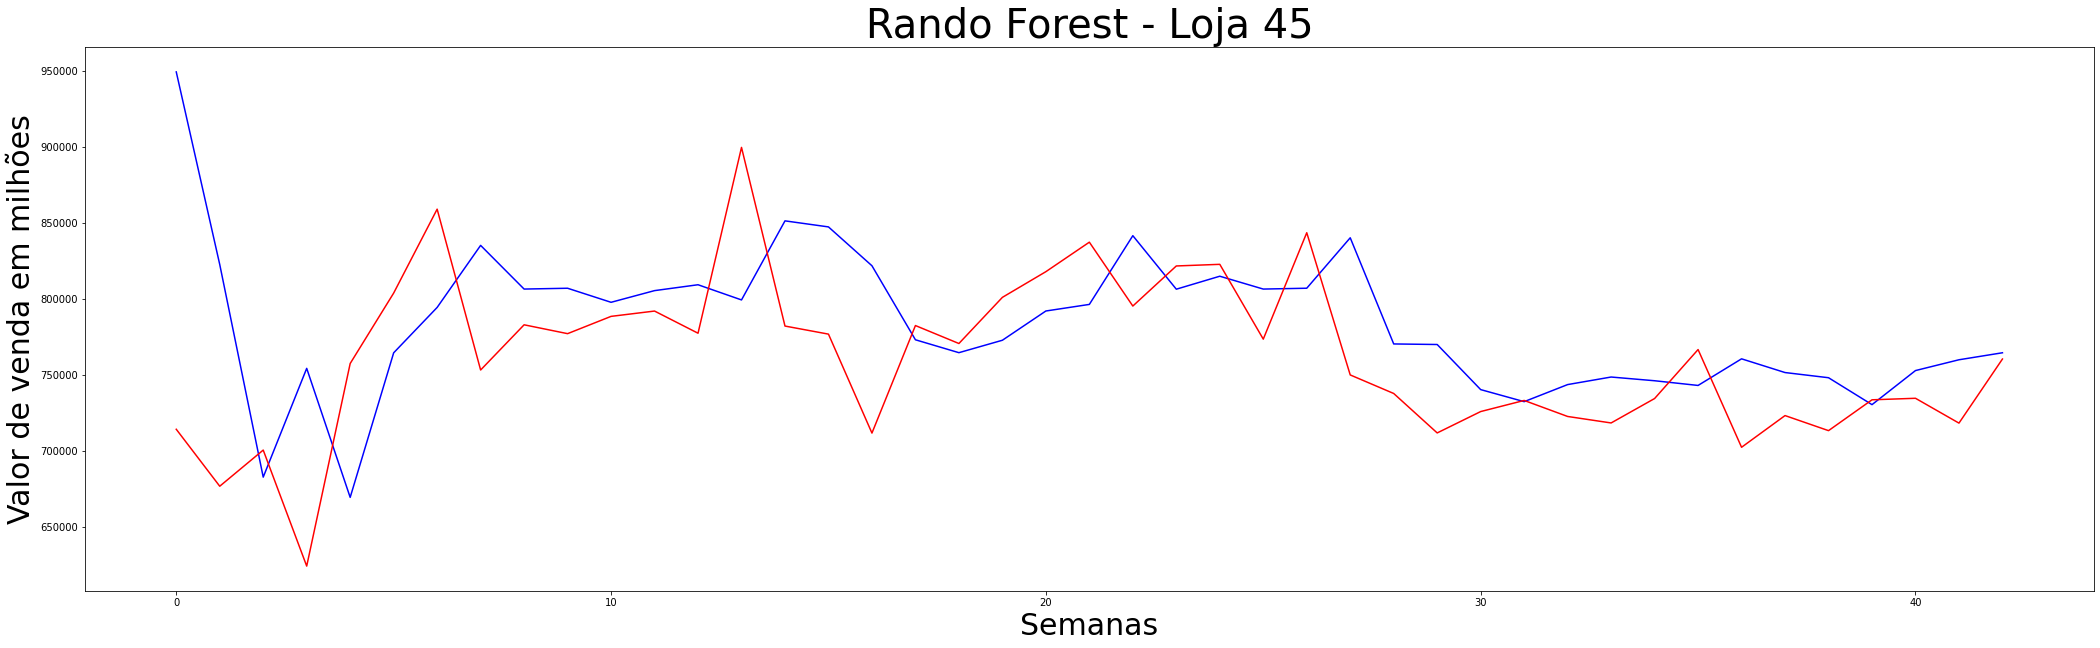

**************************************************


In [10]:
Xy_test = X_test.copy(deep=True)
Xy_test["y"] = y_test.copy()

for i in range(1, 46):
  X_loja = Xy_test.where(Xy_test["Store_" + str(i)] == 1).dropna()
  y_loja = X_loja["y"]
  X_loja = X_loja.drop(["y"], axis=1)

  predictions_loja = rf.predict(X_loja)

  print("Resultados Loja {}:".format(i))
  print(mean_absolute_error(y_loja, predictions_loja), np.sqrt(mean_squared_error(y_loja, predictions_loja)))
  
  plt.figure(figsize = (36, 10)) 
  plt.plot(range(len(predictions_loja)), predictions_loja, 'b')
  plt.plot(range(len(predictions_loja)), y_loja, 'r')
  plt.title("Rando Forest - Loja {}".format(i), fontsize=40)
  plt.xlabel("Semanas", fontsize=30)
  plt.ylabel("Valor de venda em milhões", fontsize=30)

  plt.show()
  
  print(50*"*")
